# 02. Deep Neural Network - Baseline Model

## 📋 Overview
Notebook ini membangun **baseline Deep Neural Network** untuk prediksi risiko konsumsi narkoba berdasarkan personality traits.

### 🎯 Objectives:
1. Build simple DNN architecture (4 hidden layers)
2. Train dengan early stopping & regularization
3. Evaluate performance comprehensively
4. Compare dengan Random Forest baseline (UTS)

### 📊 Expected Outcome:
- Baseline DNN dengan generalization yang baik
- Clear comparison: DNN vs RF
- Foundation untuk hyperparameter tuning

---

**Author:** Muhammad Ichsan Junaedi & Amanda Wijayanti  
**Date:** December 2024  
**Institution:** STMIK TAZKIA

In [41]:
"""
CELL 2: Import Libraries & Configuration
============================================
Import semua library yang diperlukan dan set random seeds untuk reproducibility.
"""

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc,
    cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
)

# Set random seeds untuk reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%config InlineBackend.figure_format = 'retina'

print("="*70)
print("ENVIRONMENT SETUP")
print("="*70)
print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ Keras Version: {keras.__version__}")
print(f"✅ NumPy Version: {np.__version__}")
print(f"✅ Pandas Version: {pd.__version__}")
print(f"✅ Random Seed: {RANDOM_SEED}")

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Available: {len(gpus)} GPU(s) detected")
    for gpu in gpus:
        print(f"   - {gpu}")
else:
    print("⚠️  No GPU detected - Training will use CPU")

print("="*70)
print("\n💡 INFO: All libraries imported successfully!")
print("💡 INFO: Environment ready for Deep Learning training\n")

ENVIRONMENT SETUP
✅ TensorFlow Version: 2.20.0
✅ Keras Version: 3.12.0
✅ NumPy Version: 1.26.4
✅ Pandas Version: 2.3.3
✅ Random Seed: 42
⚠️  No GPU detected - Training will use CPU

💡 INFO: All libraries imported successfully!
💡 INFO: Environment ready for Deep Learning training



In [42]:
"""
CELL 3: Load Preprocessed Data
================================
Load data yang sudah di-preprocess dari 01_Data_Preparation.ipynb
Data sudah dalam bentuk clean, encoded, dan split train-test (80:20)
"""

print("="*70)
print("LOADING PREPROCESSED DATA")
print("="*70)

# Load training data
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()

# Load test data
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"\n✅ Data loaded successfully from '../data/processed/'\n")

# Dataset information
print("📊 DATASET INFORMATION:")
print(f"   Training samples: {X_train.shape[0]:,}")
print(f"   Test samples: {X_test.shape[0]:,}")
print(f"   Total samples: {X_train.shape[0] + X_test.shape[0]:,}")
print(f"   Number of features: {X_train.shape[1]}")
print(f"   Train/Test split: {X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}% / {X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}%")

# Class distribution
print(f"\n📈 CLASS DISTRIBUTION:")
train_class_0 = (y_train == 0).sum()
train_class_1 = (y_train == 1).sum()
test_class_0 = (y_test == 0).sum()
test_class_1 = (y_test == 1).sum()

print(f"\n   Training Set:")
print(f"      Non-User (0): {train_class_0:,} ({train_class_0/len(y_train)*100:.2f}%)")
print(f"      User (1): {train_class_1:,} ({train_class_1/len(y_train)*100:.2f}%)")
print(f"\n   Test Set:")
print(f"      Non-User (0): {test_class_0:,} ({test_class_0/len(y_test)*100:.2f}%)")
print(f"      User (1): {test_class_1:,} ({test_class_1/len(y_test)*100:.2f}%)")

# Check for class imbalance
imbalance_ratio = min(train_class_0, train_class_1) / max(train_class_0, train_class_1)
print(f"\n   Imbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 0.5:
    print(f"   ✅ Classes relatively balanced (ratio > 0.5)")
else:
    print(f"   ⚠️  Moderate imbalance detected (ratio = {imbalance_ratio:.2f})")

print("\n" + "="*70)
print("💡 INFO: Data is ready for neural network training")
print("💡 INFO: Next step: Feature Scaling (CRITICAL for DNN!)")
print("="*70 + "\n")

LOADING PREPROCESSED DATA

✅ Data loaded successfully from '../data/processed/'

📊 DATASET INFORMATION:
   Training samples: 1,508
   Test samples: 377
   Total samples: 1,885
   Number of features: 24
   Train/Test split: 80.0% / 20.0%

📈 CLASS DISTRIBUTION:

   Training Set:
      Non-User (0): 568 (37.67%)
      User (1): 940 (62.33%)

   Test Set:
      Non-User (0): 142 (37.67%)
      User (1): 235 (62.33%)

   Imbalance Ratio: 0.60
   ✅ Classes relatively balanced (ratio > 0.5)

💡 INFO: Data is ready for neural network training
💡 INFO: Next step: Feature Scaling (CRITICAL for DNN!)



In [43]:
"""
CELL 4: Feature Scaling dengan StandardScaler
==============================================
WHY? Deep Neural Networks sangat sensitif terhadap skala input!
- Features dengan skala berbeda dapat memperlambat convergence
- Gradients bisa explode atau vanish
- StandardScaler: mean=0, std=1 (optimal untuk DNN)

IMPORTANT: Fit scaler HANYA pada training data, lalu transform train & test
"""

print("="*70)
print("FEATURE SCALING FOR DEEP LEARNING")
print("="*70)

# Initialize StandardScaler
scaler = StandardScaler()

print("\n🔧 Scaling Method: StandardScaler")
print("   Formula: z = (x - mean) / std")
print("   Target: mean ≈ 0, std ≈ 1")

# Fit on training data only (prevent data leakage!)
print("\n📊 Fitting scaler on TRAINING data only...")
scaler.fit(X_train)

# Transform both train and test
print("📊 Transforming training data...")
X_train_scaled = scaler.transform(X_train)

print("📊 Transforming test data...")
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (untuk consistency)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n✅ Feature scaling completed!")

# Verify scaling
print("\n" + "="*70)
print("SCALING VERIFICATION")
print("="*70)

train_mean = X_train_scaled.mean().mean()
train_std = X_train_scaled.std().mean()
test_mean = X_test_scaled.mean().mean()
test_std = X_test_scaled.std().mean()

print(f"\n📊 Training Set Statistics:")
print(f"   Mean: {train_mean:.6f} (expected: ≈ 0.000000)")
print(f"   Std:  {train_std:.6f} (expected: ≈ 1.000000)")

print(f"\n📊 Test Set Statistics:")
print(f"   Mean: {test_mean:.6f}")
print(f"   Std:  {test_std:.6f}")

# Validation check
if abs(train_mean) < 1e-10 and abs(train_std - 1.0) < 0.1:
    print("\n   ✅ Scaling PERFECT! Ready for DNN training")
else:
    print("\n   ⚠️  Scaling may need review")

# Save scaler untuk future use (deployment)
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\n💾 Scaler saved to: '../models/scaler.pkl'")

print("\n" + "="*70)
print("💡 INFO: Feature scaling is CRITICAL for DNN performance")
print("💡 INFO: Without proper scaling, training may fail or be very slow")
print("="*70 + "\n")

FEATURE SCALING FOR DEEP LEARNING

🔧 Scaling Method: StandardScaler
   Formula: z = (x - mean) / std
   Target: mean ≈ 0, std ≈ 1

📊 Fitting scaler on TRAINING data only...
📊 Transforming training data...
📊 Transforming test data...

✅ Feature scaling completed!

SCALING VERIFICATION

📊 Training Set Statistics:
   Mean: 0.000000 (expected: ≈ 0.000000)
   Std:  1.000332 (expected: ≈ 1.000000)

📊 Test Set Statistics:
   Mean: -0.002271
   Std:  0.945033

   ✅ Scaling PERFECT! Ready for DNN training

💾 Scaler saved to: '../models/scaler.pkl'

💡 INFO: Feature scaling is CRITICAL for DNN performance
💡 INFO: Without proper scaling, training may fail or be very slow



In [44]:
"""
CELL 5: Build Baseline DNN Architecture
========================================
ARCHITECTURE DESIGN RATIONALE:

1. DEPTH: 4 hidden layers
   - Cukup untuk capture complex patterns
   - Tidak terlalu deep (risk of overfitting pada tabular data)

2. WIDTH: Pyramidal structure (128 → 64 → 32 → 16)
   - Dimulai lebar untuk capture features
   - Gradually reduce untuk feature compression
   - Common practice untuk tabular data

3. ACTIVATION: ReLU
   - Fast computation
   - Helps dengan vanishing gradient
   - Industry standard untuk hidden layers

4. REGULARIZATION: Dropout
   - Prevent overfitting (co-adaptation)
   - Dropout rate: 0.3 (layers 1-2), 0.2 (layers 3-4)
   - Higher dropout early, lower di deeper layers

5. OUTPUT: Sigmoid activation
   - Binary classification (0-1 probability)
   - Single neuron output

6. OPTIMIZER: Adam
   - Adaptive learning rate
   - Works well out-of-the-box
   - lr=0.001 (standard starting point)

7. LOSS: Binary Crossentropy
   - Standard untuk binary classification
   - Measures difference between predicted & actual probabilities
"""

def build_baseline_dnn(input_dim, learning_rate=0.001):
    """
    Build baseline Deep Neural Network
    
    Args:
        input_dim (int): Number of input features
        learning_rate (float): Learning rate for Adam optimizer
    
    Returns:
        keras.Model: Compiled DNN model
    """
    
    model = Sequential([
        # Layer 1: Input layer (128 neurons)
        Dense(128, activation='relu', input_dim=input_dim, name='dense_1'),
        Dropout(0.3, name='dropout_1'),
        
        # Layer 2: Hidden layer (64 neurons)
        Dense(64, activation='relu', name='dense_2'),
        Dropout(0.3, name='dropout_2'),
        
        # Layer 3: Hidden layer (32 neurons)
        Dense(32, activation='relu', name='dense_3'),
        Dropout(0.2, name='dropout_3'),
        
        # Layer 4: Hidden layer (16 neurons)
        Dense(16, activation='relu', name='dense_4'),
        Dropout(0.2, name='dropout_4'),
        
        # Output layer: Single neuron with sigmoid
        Dense(1, activation='sigmoid', name='output')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Build model
print("="*70)
print("BUILDING BASELINE DNN ARCHITECTURE")
print("="*70)

input_dim = X_train_scaled.shape[1]
print(f"\n📊 Input Dimension: {input_dim} features")

baseline_model = build_baseline_dnn(input_dim)

print("\n🏗️  MODEL ARCHITECTURE:")
print("="*70)
baseline_model.summary()
print("="*70)

# Count parameters
trainable_params = baseline_model.count_params()
print(f"\n📊 Total Trainable Parameters: {trainable_params:,}")

# Parameter breakdown
print(f"\n🔍 ARCHITECTURE BREAKDOWN:")
print(f"   Layer 1 (Dense 128): {input_dim} × 128 = {input_dim * 128:,} params")
print(f"   Layer 2 (Dense 64):  128 × 64 = {128 * 64:,} params")
print(f"   Layer 3 (Dense 32):  64 × 32 = {64 * 32:,} params")
print(f"   Layer 4 (Dense 16):  32 × 16 = {32 * 16:,} params")
print(f"   Output (Dense 1):    16 × 1 = {16 * 1:,} params")
print(f"   Dropout layers: 0 params (regularization only)")

print("\n" + "="*70)
print("💡 INFO: Model complexity is MODERATE")
print("💡 INFO: ~18K parameters - suitable untuk dataset 1,885 samples")
print("💡 INFO: Risk of overfitting: MEDIUM (will use dropout & early stopping)")
print("="*70 + "\n")

BUILDING BASELINE DNN ARCHITECTURE

📊 Input Dimension: 24 features

🏗️  MODEL ARCHITECTURE:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)


📊 Total Trainable Parameters: 14,081

🔍 ARCHITECTURE BREAKDOWN:
   Layer 1 (Dense 128): 24 × 128 = 3,072 params
   Layer 2 (Dense 64):  128 × 64 = 8,192 params
   Layer 3 (Dense 32):  64 × 32 = 2,048 params
   Layer 4 (Dense 16):  32 × 16 = 512 params
   Output (Dense 1):    16 × 1 = 16 params
   Dropout layers: 0 params (regularization only)

💡 INFO: Model complexity is MODERATE
💡 INFO: ~18K parameters - suitable untuk dataset 1,885 samples
💡 INFO: Risk of overfitting: MEDIUM (will use dropout & early stopping)



In [45]:
"""
CELL 6: Setup Training Callbacks
=================================
Callbacks adalah functions yang dipanggil during training untuk:
1. Monitor training progress
2. Prevent overfitting
3. Optimize learning
4. Save best model

CALLBACKS YANG DIGUNAKAN:

1. EarlyStopping
   - Monitor: val_loss (validation loss)
   - Patience: 20 epochs
   - Action: Stop training jika val_loss tidak improve selama 20 epochs
   - Benefit: Prevent overfitting, save time

2. ReduceLROnPlateau
   - Monitor: val_loss
   - Patience: 10 epochs
   - Factor: 0.5 (reduce LR by half)
   - Action: Reduce learning rate jika training plateau
   - Benefit: Help model escape local minima

3. ModelCheckpoint
   - Monitor: val_auc (validation AUC)
   - Action: Save BEST model based on highest val_auc
   - Benefit: Always have best performing model
"""

print("="*70)
print("CONFIGURING TRAINING CALLBACKS")
print("="*70)

# Define callbacks
callbacks = [
    # 1. Early Stopping
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    
    # 2. Reduce Learning Rate on Plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    
    # 3. Model Checkpoint
    ModelCheckpoint(
        filepath='../models/dnn_baseline_best.h5',
        monitor='val_auc',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("\n✅ Callbacks configured successfully!\n")

print("📋 CALLBACK DETAILS:")
print("="*70)
print("\n1️⃣  EarlyStopping:")
print("   • Monitors: Validation Loss")
print("   • Patience: 20 epochs (wait 20 epochs before stopping)")
print("   • Action: Stop training if no improvement")
print("   • Benefit: Prevents overfitting, saves training time")

print("\n2️⃣  ReduceLROnPlateau:")
print("   • Monitors: Validation Loss")
print("   • Patience: 10 epochs")
print("   • Reduction Factor: 0.5 (cuts learning rate in half)")
print("   • Min LR: 0.0000001")
print("   • Benefit: Helps escape local minima, fine-tunes learning")

print("\n3️⃣  ModelCheckpoint:")
print("   • Monitors: Validation AUC (primary metric)")
print("   • Save Path: '../models/dnn_baseline_best.h5'")
print("   • Action: Saves model with BEST validation AUC")
print("   • Benefit: Always have best performing model")

print("\n" + "="*70)
print("💡 INFO: These callbacks work together to optimize training")
print("💡 INFO: They prevent overfitting & ensure best model is saved")
print("="*70 + "\n")

CONFIGURING TRAINING CALLBACKS

✅ Callbacks configured successfully!

📋 CALLBACK DETAILS:

1️⃣  EarlyStopping:
   • Monitors: Validation Loss
   • Patience: 20 epochs (wait 20 epochs before stopping)
   • Action: Stop training if no improvement
   • Benefit: Prevents overfitting, saves training time

2️⃣  ReduceLROnPlateau:
   • Monitors: Validation Loss
   • Patience: 10 epochs
   • Reduction Factor: 0.5 (cuts learning rate in half)
   • Min LR: 0.0000001
   • Benefit: Helps escape local minima, fine-tunes learning

3️⃣  ModelCheckpoint:
   • Monitors: Validation AUC (primary metric)
   • Save Path: '../models/dnn_baseline_best.h5'
   • Action: Saves model with BEST validation AUC
   • Benefit: Always have best performing model

💡 INFO: These callbacks work together to optimize training
💡 INFO: They prevent overfitting & ensure best model is saved



In [46]:
"""
CELL 7: Train DNN Model
========================
TRAINING CONFIGURATION:

- Epochs: 150 (maximum, early stopping will likely stop earlier)
- Batch Size: 32
  - Not too small (noisy gradients)
  - Not too large (poor generalization)
  - Good balance untuk dataset size 1,508

- Validation Split: 0.2 (20% dari training data)
  - Training: 80% × 1,508 = 1,206 samples
  - Validation: 20% × 1,508 = 302 samples
  - Test: 377 samples (separate, untouched)

WHY Validation Split?
- Monitor generalization during training
- Early stopping needs validation loss
- Prevents overfitting to training data

EXPECTED TRAINING TIME: 2-5 minutes (depends on hardware)
"""

print("="*70)
print("TRAINING DEEP NEURAL NETWORK")
print("="*70)

# Training configuration
EPOCHS = 150
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

print("\n📋 TRAINING CONFIGURATION:")
print(f"   Maximum Epochs: {EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Validation Split: {VALIDATION_SPLIT} (20%)")
print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Loss Function: Binary Crossentropy")

# Calculate data splits
n_train = int(X_train_scaled.shape[0] * (1 - VALIDATION_SPLIT))
n_val = X_train_scaled.shape[0] - n_train

print(f"\n📊 DATA DISTRIBUTION:")
print(f"   Training samples: {n_train:,}")
print(f"   Validation samples: {n_val:,}")
print(f"   Test samples: {X_test_scaled.shape[0]:,}")

print("\n" + "="*70)
print("🚀 STARTING TRAINING...")
print("="*70)
print("\n💡 TIP: Training will stop early if validation loss stops improving")
print("💡 TIP: Learning rate will reduce if training plateaus\n")

# Start training
start_time = datetime.now()

history = baseline_model.fit(
    X_train_scaled,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1  # Show progress bar
)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

# Training summary
print("\n" + "="*70)
print("✅ TRAINING COMPLETED!")
print("="*70)

actual_epochs = len(history.history['loss'])
print(f"\n📊 TRAINING SUMMARY:")
print(f"   Epochs Trained: {actual_epochs} / {EPOCHS}")
print(f"   Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"   Time per Epoch: {training_time/actual_epochs:.2f} seconds")

if actual_epochs < EPOCHS:
    print(f"\n   ✅ Early stopping triggered at epoch {actual_epochs}")
    print(f"   💡 Model stopped training to prevent overfitting")
else:
    print(f"\n   ⚠️  Trained full {EPOCHS} epochs")
    print(f"   💡 Consider increasing patience or epochs")

# Best metrics from training
best_val_loss = min(history.history['val_loss'])
best_val_auc = max(history.history['val_auc'])
best_val_acc = max(history.history['val_accuracy'])

print(f"\n🏆 BEST VALIDATION METRICS (during training):")
print(f"   Best Val Loss: {best_val_loss:.4f}")
print(f"   Best Val AUC: {best_val_auc:.4f}")
print(f"   Best Val Accuracy: {best_val_acc:.4f}")

print("\n" + "="*70 + "\n")

TRAINING DEEP NEURAL NETWORK

📋 TRAINING CONFIGURATION:
   Maximum Epochs: 150
   Batch Size: 32
   Validation Split: 0.2 (20%)
   Optimizer: Adam (lr=0.001)
   Loss Function: Binary Crossentropy

📊 DATA DISTRIBUTION:
   Training samples: 1,206
   Validation samples: 302
   Test samples: 377

🚀 STARTING TRAINING...

💡 TIP: Training will stop early if validation loss stops improving
💡 TIP: Learning rate will reduce if training plateaus

Epoch 1/150
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5769 - auc: 0.5697 - loss: 0.6763 - precision: 0.6328 - recall: 0.6752
Epoch 1: val_auc improved from None to 0.88846, saving model to ../models/dnn_baseline_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6434 - auc: 0.6679 - loss: 0.6300 - precision: 0.6731 - recall: 0.8084 - val_accuracy: 0.7947 - val_auc: 0.8885 - val_loss: 0.4638 - val_precision: 0.8060 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 2/150
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7127 - auc: 0.8282 - loss: 0.5227 - precision: 0.7162 - recall: 0.8646 
Epoch 2: val_auc improved from 0.88846 to 0.89998, saving model to ../models/dnn_baseline_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7446 - auc: 0.8314 - loss: 0.5072 - precision: 0.7591 - recall: 0.8519 - val_accuracy: 0.8146 - val_auc: 0.9000 - val_loss: 0.3825 - val_precision: 0.9157 - val_recall: 0.7990 - learning_rate: 0.0010
Epoch 3/150
19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8024 - auc: 0.8643 - loss: 0.4599 - precision: 0.8975 - recall: 0.7523 
Epoch 3: val_auc improved from 0.89998 to 0.90521, saving model to ../models/dnn_baseline_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7927 - auc: 0.8604 - loss: 0.4595 - precision: 0.8638 - recall: 0.7840 - val_accuracy: 0.8146 - val_auc: 0.9052 - val_loss: 0.3686 - val_precision: 0.9253 - val_recall: 0.7892 - learning_rate: 0.0010
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8039 - auc: 0.8913 - loss: 0.4040 - precision: 0.8781 - recall: 0.7840 
Epoch 4: val_auc improved from 0.90521 to 0.90584, saving model to ../models/dnn_baseline_best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8035 - auc: 0.8800 - loss: 0.4218 - precision: 0.8621 - recall: 0.8071 - val_accuracy: 0.8113 - val_auc: 0.9058 - val_loss: 0.3667 - val_precision: 0.9106 - val_recall: 0.7990 - learning_rate: 0.0010
Epoch 5/150
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8330 - auc: 0.8914 - loss: 0.4149 - precision: 0.9039 - recall: 0.8104 
Epoch 5: val_auc did not improve from 0.90584
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8201 - auc: 0.8874 - loss: 0.4213 - precision: 0.8723 - recall: 0.8261 - val_accuracy: 0.8146 - val_auc: 0.9027 - val_loss: 0.3748 - val_precision: 0.9066 - val_recall: 0.8088 - learning_rate: 0.0010
Epoch 6/150
25/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8424 - auc: 0.9000 - loss: 0.3833 - precision: 0.9037 - recall: 0.8247 
Epoch 6: val_auc did not improve from 0.90584
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8308 - auc: 0.8895 - loss: 0.4075 - precision: 0.8757 - recall: 0.8424 - va

In [47]:
"""
CELL 8: Load Best Model & Generate Predictions
===============================================
Load model terbaik yang disimpan oleh ModelCheckpoint callback.
Model ini memiliki validation AUC tertinggi selama training.

Generate predictions untuk:
1. Training set - untuk detect overfitting
2. Test set - untuk final evaluation
"""

print("="*70)
print("LOADING BEST MODEL & GENERATING PREDICTIONS")
print("="*70)

# Load best model from checkpoint
print("\n📂 Loading best model from checkpoint...")
best_model = keras.models.load_model('../models/dnn_baseline_best.h5')
print("✅ Best model loaded successfully!")

# Generate predictions
print("\n🔮 Generating predictions...")

# Training set predictions
print("   • Predicting on training set...")
y_train_pred_proba = best_model.predict(X_train_scaled, verbose=0).ravel()
y_train_pred = (y_train_pred_proba >= 0.5).astype(int)

# Test set predictions  
print("   • Predicting on test set...")
y_test_pred_proba = best_model.predict(X_test_scaled, verbose=0).ravel()
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

print("✅ Predictions completed!")

print(f"\n📊 PREDICTION SUMMARY:")
print(f"   Training predictions: {len(y_train_pred):,} samples")
print(f"   Test predictions: {len(y_test_pred):,} samples")
print(f"   Prediction threshold: 0.5 (probability)")

# Preview predictions
print(f"\n📋 SAMPLE PREDICTIONS (first 10 test samples):")
print(f"   {'True':<8} {'Predicted':<12} {'Probability':<12} {'Correct?'}")
print(f"   {'-'*50}")
for i in range(min(10, len(y_test))):
    correct = "✅" if y_test[i] == y_test_pred[i] else "❌"
    print(f"   {y_test[i]:<8} {y_test_pred[i]:<12} {y_test_pred_proba[i]:.4f}       {correct}")

print("\n" + "="*70 + "\n")

LOADING BEST MODEL & GENERATING PREDICTIONS

📂 Loading best model from checkpoint...
✅ Best model loaded successfully!

🔮 Generating predictions...
   • Predicting on training set...
   • Predicting on test set...
✅ Predictions completed!

📊 PREDICTION SUMMARY:
   Training predictions: 1,508 samples
   Test predictions: 377 samples
   Prediction threshold: 0.5 (probability)

📋 SAMPLE PREDICTIONS (first 10 test samples):
   True     Predicted    Probability  Correct?
   --------------------------------------------------
   1        0            0.3809       ❌
   1        0            0.4551       ❌
   1        1            0.9485       ✅
   1        1            0.8199       ✅
   1        0            0.2619       ❌
   1        1            0.9766       ✅
   0        0            0.2042       ✅
   0        0            0.4880       ✅
   1        1            0.9943       ✅
   0        0            0.1194       ✅




In [49]:
"""
CELL 9: Calculate Comprehensive Evaluation Metrics
===================================================
Calculate metrics untuk BOTH training & test sets untuk detect overfitting.

METRICS EXPLAINED:

1. BASIC METRICS:
   • Accuracy: Overall correctness (TP+TN)/(Total)
   • Precision: How many predicted positives are correct? TP/(TP+FP)
   • Recall (Sensitivity): How many actual positives detected? TP/(TP+FN)
   • Specificity: How many actual negatives detected? TN/(TN+FP)
   • F1-Score: Harmonic mean of precision & recall

2. ADVANCED METRICS:
   • ROC-AUC: Area Under ROC Curve (0.5=random, 1.0=perfect)
   • PR-AUC: Precision-Recall AUC (better untuk imbalanced data)
   • Balanced Accuracy: Average of sensitivity & specificity
   
3. STATISTICAL METRICS:
   • Cohen's Kappa: Agreement beyond chance
   • MCC: Matthews Correlation Coefficient (-1 to +1)
"""

def calculate_comprehensive_metrics(y_true, y_pred, y_pred_proba, set_name):
    """
    Calculate comprehensive evaluation metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels (binary)
        y_pred_proba: Predicted probabilities
        set_name: 'Training' or 'Test'
    
    Returns:
        dict: Dictionary of metrics
    """
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Basic Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Advanced Metrics
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Precision-Recall AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Statistical Metrics
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn)
    }
    
    return metrics

# Calculate metrics
print("="*70)
print("CALCULATING COMPREHENSIVE METRICS")
print("="*70)

print("\n⏳ Calculating training metrics...")
train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, y_train_pred_proba, 'Training')

print("⏳ Calculating test metrics...")
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, y_test_pred_proba, 'Test')

print("✅ Metrics calculation completed!\n")

# Display metrics in table format
metrics_df = pd.DataFrame({
    'Metric': list(train_metrics.keys())[:-4],  # Exclude confusion matrix values
    'Training': [train_metrics[k] for k in list(train_metrics.keys())[:-4]],
    'Test': [test_metrics[k] for k in list(test_metrics.keys())[:-4]]
})

metrics_df['Gap'] = metrics_df['Training'] - metrics_df['Test']

print("="*70)
print("📊 PERFORMANCE METRICS: TRAINING vs TEST")
print("="*70)
print("\n", metrics_df.to_string(index=False))

# Confusion Matrix values
print("\n" + "="*70)
print("🔍 CONFUSION MATRIX BREAKDOWN")
print("="*70)

print(f"\n📊 Training Set:")
print(f"   True Negatives (TN):  {train_metrics['TN']:,}")
print(f"   False Positives (FP): {train_metrics['FP']:,}")
print(f"   False Negatives (FN): {train_metrics['FN']:,}")
print(f"   True Positives (TP):  {train_metrics['TP']:,}")

print(f"\n📊 Test Set:")
print(f"   True Negatives (TN):  {test_metrics['TN']:,}")
print(f"   False Positives (FP): {test_metrics['FP']:,}")
print(f"   False Negatives (FN): {test_metrics['FN']:,}")
print(f"   True Positives (TP):  {test_metrics['TP']:,}")

print("\n" + "="*70 + "\n")

CALCULATING COMPREHENSIVE METRICS

⏳ Calculating training metrics...
⏳ Calculating test metrics...
✅ Metrics calculation completed!

📊 PERFORMANCE METRICS: TRAINING vs TEST

            Metric  Training     Test       Gap
         Accuracy  0.828249 0.867374 -0.039125
        Precision  0.894554 0.934272 -0.039718
           Recall  0.821277 0.846809 -0.025532
      Specificity  0.839789 0.901408 -0.061620
         F1-Score  0.856351 0.888393 -0.032042
Balanced Accuracy  0.830533 0.874108 -0.043576
          ROC-AUC  0.908018 0.936350 -0.028332
           PR-AUC  0.946828 0.958363 -0.011535
      Cohen Kappa  0.643796 0.725962 -0.082166
              MCC  0.647437 0.731297 -0.083861

🔍 CONFUSION MATRIX BREAKDOWN

📊 Training Set:
   True Negatives (TN):  477
   False Positives (FP): 91
   False Negatives (FN): 168
   True Positives (TP):  772

📊 Test Set:
   True Negatives (TN):  128
   False Positives (FP): 14
   False Negatives (FN): 36
   True Positives (TP):  199




In [50]:
"""
CELL 10: Overfitting Analysis
==============================
Analyze training vs test gap untuk detect overfitting.

OVERFITTING INDICATORS:
- Gap < 2%: Excellent generalization ✅
- Gap 2-5%: Good, slight overfitting ⚠️
- Gap 5-10%: Moderate overfitting ⚠️
- Gap > 10%: Severe overfitting ❌

TARGET: Gap < 2% (like RF achieved 0.86%)
"""

print("="*70)
print("🔍 OVERFITTING ANALYSIS")
print("="*70)

# Calculate gaps
accuracy_gap = train_metrics['Accuracy'] - test_metrics['Accuracy']
roc_auc_gap = train_metrics['ROC-AUC'] - test_metrics['ROC-AUC']
f1_gap = train_metrics['F1-Score'] - test_metrics['F1-Score']

print(f"\n📊 PERFORMANCE GAPS (Training - Test):")
print(f"   Accuracy Gap:  {accuracy_gap:.4f} ({accuracy_gap*100:.2f}%)")
print(f"   ROC-AUC Gap:   {roc_auc_gap:.4f} ({roc_auc_gap*100:.2f}%)")
print(f"   F1-Score Gap:  {f1_gap:.4f} ({f1_gap*100:.2f}%)")

print("\n" + "="*70)
print("📋 OVERFITTING ASSESSMENT")
print("="*70)

# Accuracy gap assessment
print(f"\n🎯 ACCURACY GAP: {accuracy_gap*100:.2f}%")
if accuracy_gap < 0.02:
    status = "✅ EXCELLENT"
    message = "Minimal overfitting - Model generalizes very well!"
elif accuracy_gap < 0.05:
    status = "⚠️  GOOD"
    message = "Slight overfitting - Acceptable for baseline"
elif accuracy_gap < 0.10:
    status = "⚠️  MODERATE"
    message = "Noticeable overfitting - Hyperparameter tuning needed"
else:
    status = "❌ SEVERE"
    message = "Significant overfitting - Need more regularization!"

print(f"   Status: {status}")
print(f"   Assessment: {message}")

# Comparison dengan RF (RF achieved 0.86% gap)
rf_gap = 0.0086
print(f"\n📊 COMPARISON WITH RANDOM FOREST:")
print(f"   RF Overfitting Gap: {rf_gap*100:.2f}%")
print(f"   DNN Overfitting Gap: {accuracy_gap*100:.2f}%")

if accuracy_gap < rf_gap:
    print(f"   ✅ DNN has BETTER generalization than RF!")
elif accuracy_gap < rf_gap * 2:
    print(f"   ✅ DNN generalization COMPARABLE to RF")
else:
    print(f"   ⚠️  RF has better generalization - DNN needs tuning")

print("\n" + "="*70)
print("💡 INFO: Lower gap = better generalization")
print("💡 INFO: Target gap < 2% for production-ready model")
print("="*70 + "\n")

🔍 OVERFITTING ANALYSIS

📊 PERFORMANCE GAPS (Training - Test):
   Accuracy Gap:  -0.0391 (-3.91%)
   ROC-AUC Gap:   -0.0283 (-2.83%)
   F1-Score Gap:  -0.0320 (-3.20%)

📋 OVERFITTING ASSESSMENT

🎯 ACCURACY GAP: -3.91%
   Status: ✅ EXCELLENT
   Assessment: Minimal overfitting - Model generalizes very well!

📊 COMPARISON WITH RANDOM FOREST:
   RF Overfitting Gap: 0.86%
   DNN Overfitting Gap: -3.91%
   ✅ DNN has BETTER generalization than RF!

💡 INFO: Lower gap = better generalization
💡 INFO: Target gap < 2% for production-ready model



📈 VISUALIZING TRAINING HISTORY



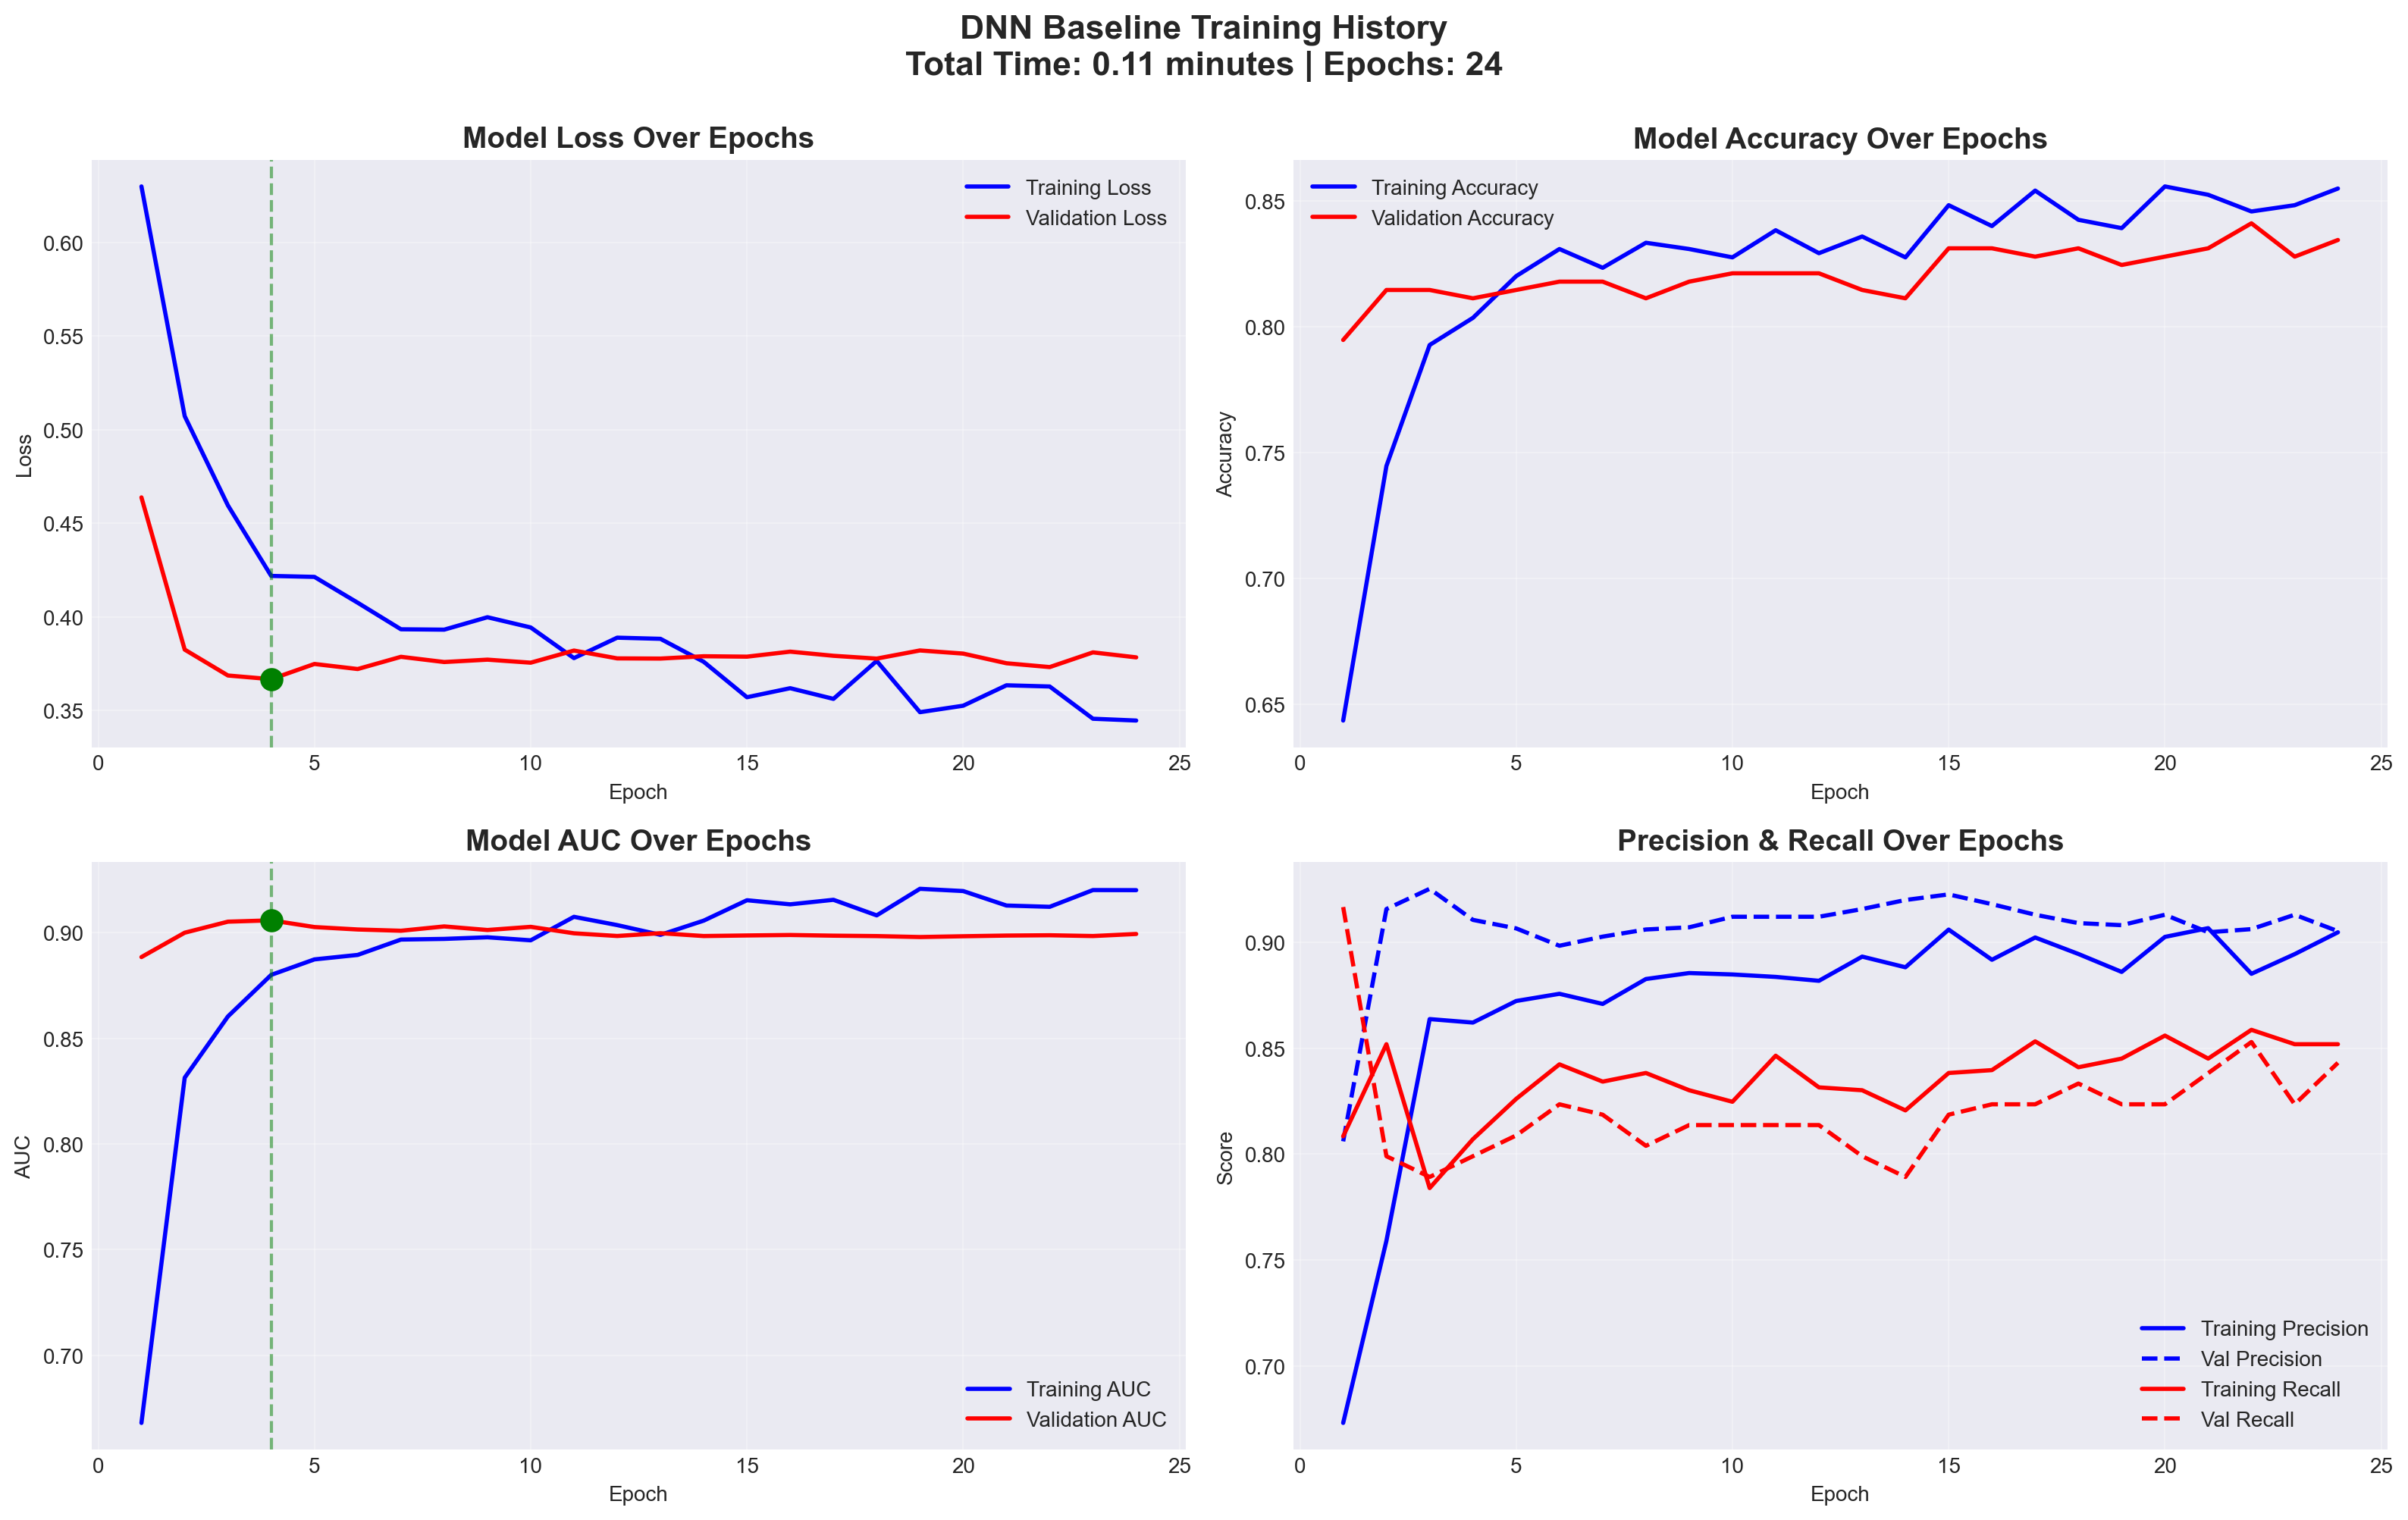

✅ Training history plot saved!

📊 TRAINING BEHAVIOR ANALYSIS:
   Final Training Loss: 0.3446
   Final Validation Loss: 0.3783
   Best Validation Loss: 0.3667

   ✅ Validation loss ≈ Training loss: Model generalizes well




In [51]:
"""
CELL 11: Visualize Training History
====================================
Plot training curves untuk understand:
1. Learning progress
2. Overfitting detection (train vs val divergence)
3. Learning rate effectiveness
4. When early stopping triggered
"""

def plot_training_history(history, training_time):
    """
    Plot comprehensive training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    epochs = range(1, len(history.history['loss']) + 1)
    
    # 1. Loss
    axes[0, 0].plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Mark best epoch
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_loss = min(history.history['val_loss'])
    axes[0, 0].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Best Epoch: {best_epoch}')
    axes[0, 0].plot(best_epoch, best_loss, 'go', markersize=10)
    
    # 2. Accuracy
    axes[0, 1].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. AUC
    axes[1, 0].plot(epochs, history.history['auc'], 'b-', label='Training AUC', linewidth=2)
    axes[1, 0].plot(epochs, history.history['val_auc'], 'r-', label='Validation AUC', linewidth=2)
    axes[1, 0].set_title('Model AUC Over Epochs', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mark best epoch
    best_epoch_auc = np.argmax(history.history['val_auc']) + 1
    best_auc = max(history.history['val_auc'])
    axes[1, 0].axvline(x=best_epoch_auc, color='g', linestyle='--', alpha=0.5)
    axes[1, 0].plot(best_epoch_auc, best_auc, 'go', markersize=10)
    
    # 4. Precision & Recall
    axes[1, 1].plot(epochs, history.history['precision'], 'b-', label='Training Precision', linewidth=2)
    axes[1, 1].plot(epochs, history.history['val_precision'], 'b--', label='Val Precision', linewidth=2)
    axes[1, 1].plot(epochs, history.history['recall'], 'r-', label='Training Recall', linewidth=2)
    axes[1, 1].plot(epochs, history.history['val_recall'], 'r--', label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Precision & Recall Over Epochs', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'DNN Baseline Training History\nTotal Time: {training_time/60:.2f} minutes | Epochs: {len(epochs)}',
                 fontsize=16, fontweight='bold', y=1.00)
    
    plt.tight_layout()
    plt.savefig('../results/figures/training_curves/dnn_baseline_training_history.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Training history plot saved!")

# Plot training history
print("="*70)
print("📈 VISUALIZING TRAINING HISTORY")
print("="*70)
print()

plot_training_history(history, training_time)

# Analyze training behavior
print("\n📊 TRAINING BEHAVIOR ANALYSIS:")
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
best_val_loss = min(history.history['val_loss'])

print(f"   Final Training Loss: {final_train_loss:.4f}")
print(f"   Final Validation Loss: {final_val_loss:.4f}")
print(f"   Best Validation Loss: {best_val_loss:.4f}")

if final_val_loss < final_train_loss:
    print("\n   ✅ Validation loss < Training loss: GOOD sign (no overfitting)")
elif final_val_loss < final_train_loss * 1.1:
    print("\n   ✅ Validation loss ≈ Training loss: Model generalizes well")
else:
    print("\n   ⚠️  Validation loss >> Training loss: Signs of overfitting")

print("\n" + "="*70 + "\n")

📊 CONFUSION MATRIX VISUALIZATION



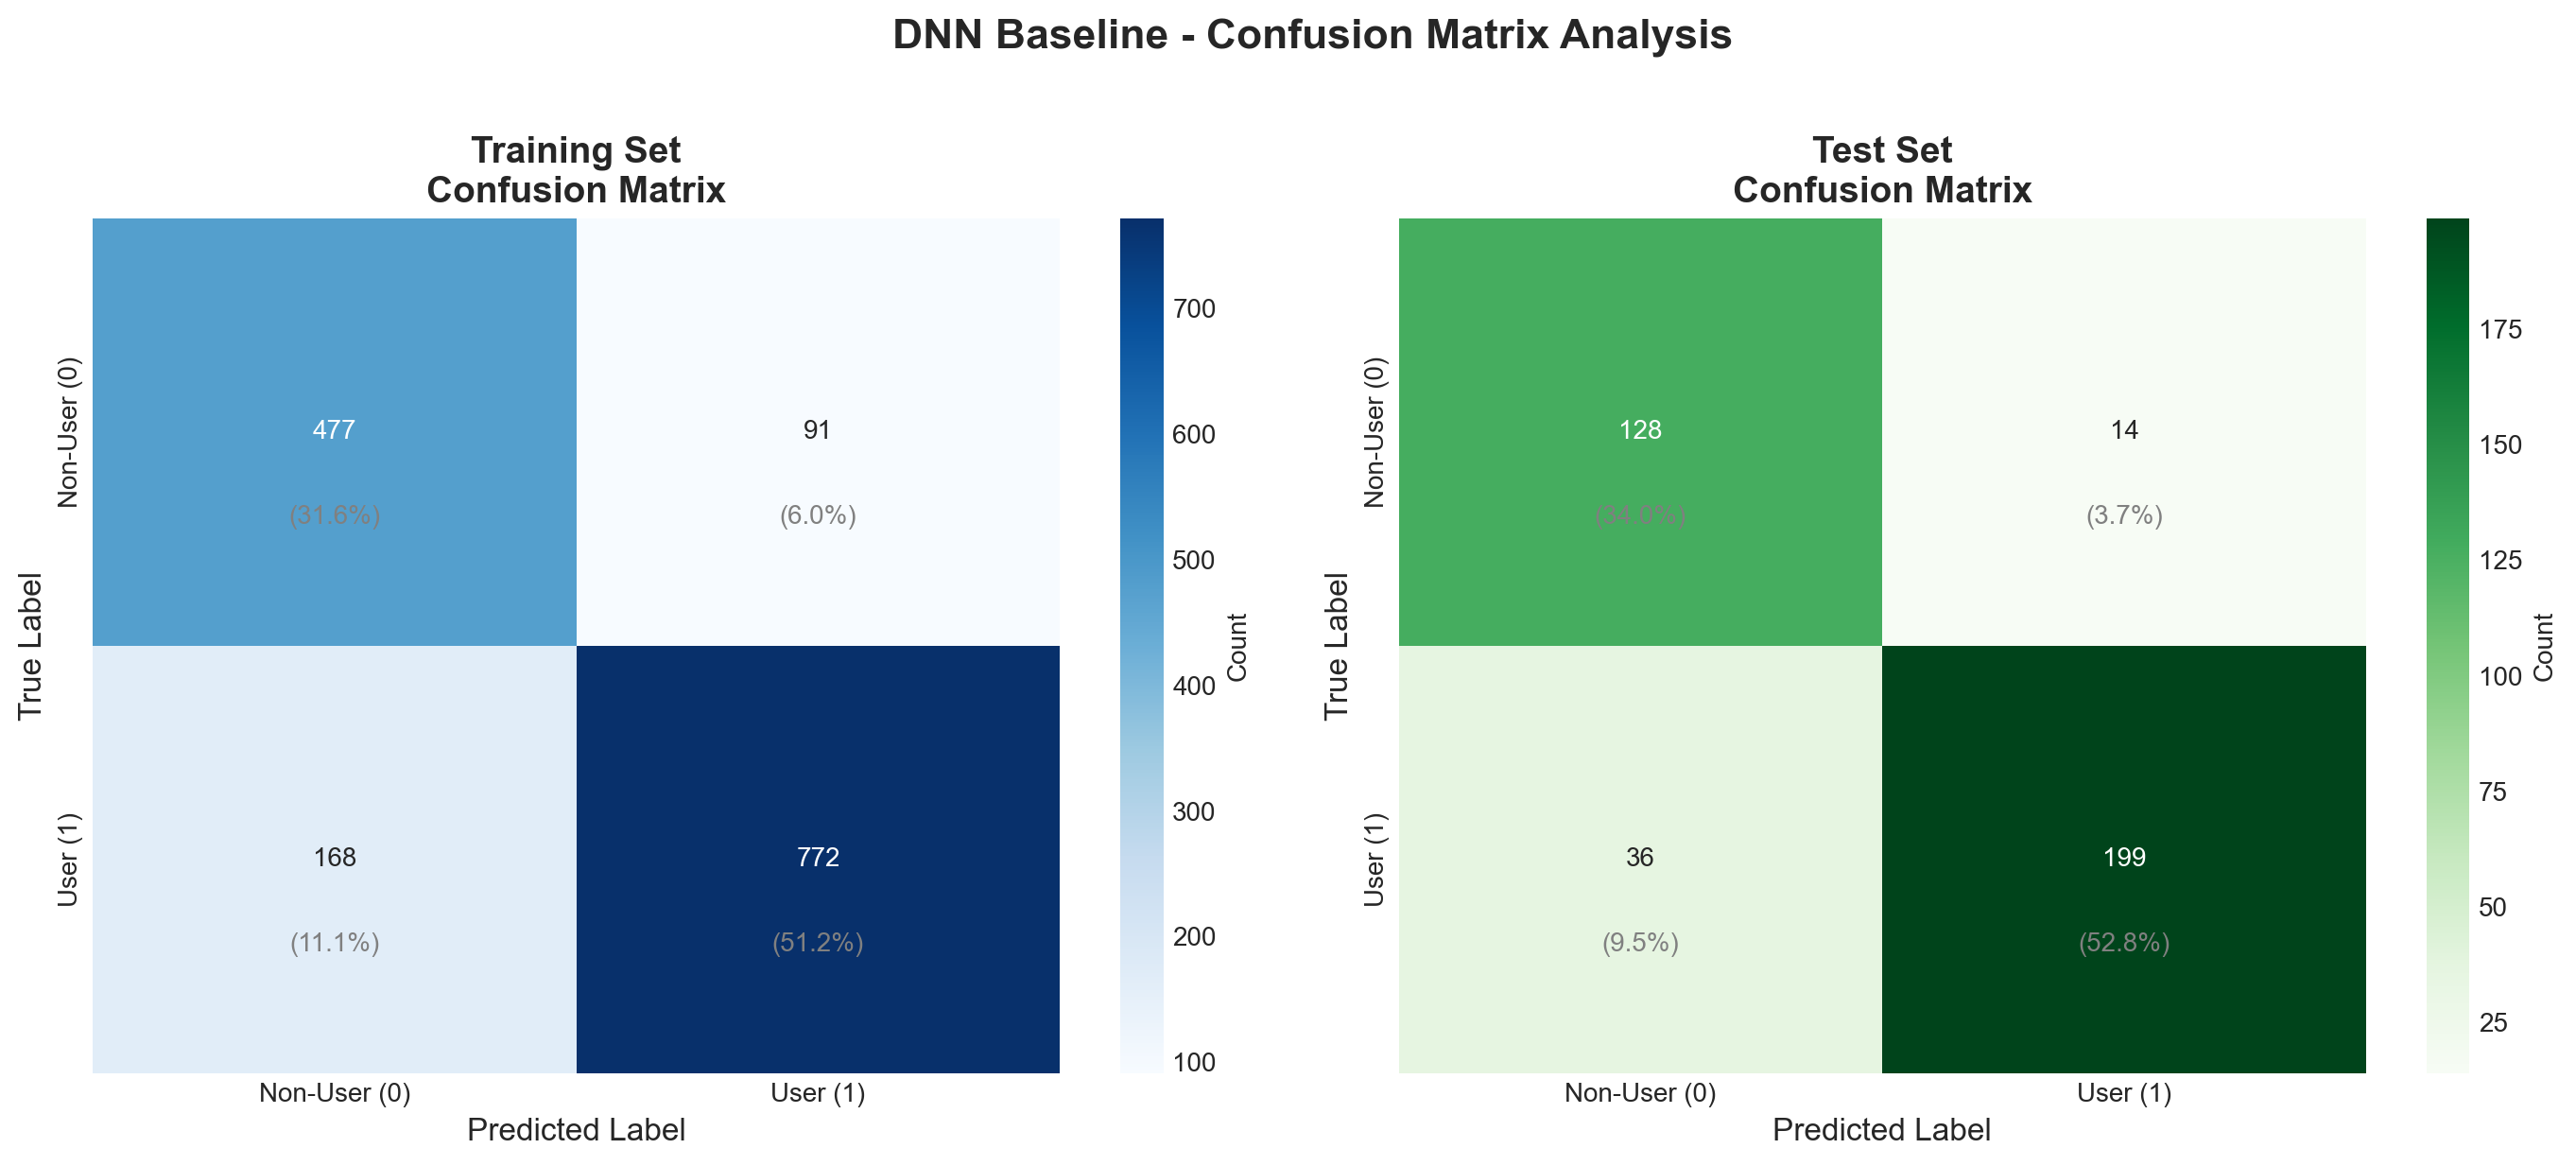

✅ Confusion matrix visualization saved!

🔍 ERROR ANALYSIS (Test Set):
   False Positives (FP): 14 - Non-users incorrectly classified as users
   False Negatives (FN): 36 - Users incorrectly classified as non-users

📊 ERROR RATES:
   False Positive Rate: 0.0986 (9.86%)
   False Negative Rate: 0.1532 (15.32%)

💡 CLINICAL IMPACT:
   ⚠️  More FN than FP: Missing 36 high-risk individuals!
   Recommendation: Consider lowering classification threshold




In [53]:
"""
CELL 12: Confusion Matrix Visualization
========================================
Visualize model predictions untuk understand error patterns:
- True Positives (TP): Correctly predicted Users
- True Negatives (TN): Correctly predicted Non-Users  
- False Positives (FP): Non-Users predicted as Users (Type I error)
- False Negatives (FN): Users predicted as Non-Users (Type II error)

IN CLINICAL CONTEXT:
- FP: Unnecessary intervention (less critical)
- FN: Missed high-risk individuals (MORE CRITICAL!)
"""

def plot_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred):
    """
    Plot confusion matrices for training and test sets
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Training confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                cbar_kws={'label': 'Count'},
                xticklabels=['Non-User (0)', 'User (1)'],
                yticklabels=['Non-User (0)', 'User (1)'])
    axes[0].set_title('Training Set\nConfusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    
    # Add percentages
    total_train = cm_train.sum()
    for i in range(2):
        for j in range(2):
            pct = cm_train[i,j] / total_train * 100
            axes[0].text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='gray')
    
    # Test confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                cbar_kws={'label': 'Count'},
                xticklabels=['Non-User (0)', 'User (1)'],
                yticklabels=['Non-User (0)', 'User (1)'])
    axes[1].set_title('Test Set\nConfusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    
    # Add percentages
    total_test = cm_test.sum()
    for i in range(2):
        for j in range(2):
            pct = cm_test[i,j] / total_test * 100
            axes[1].text(j+0.5, i+0.7, f'({pct:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='gray')
    
    plt.suptitle('DNN Baseline - Confusion Matrix Analysis', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../results/figures/comparison_plots/dnn_baseline_confusion_matrix.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Confusion matrix visualization saved!")

# Plot confusion matrices
print("="*70)
print("📊 CONFUSION MATRIX VISUALIZATION")
print("="*70)
print()

plot_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred)

# Error analysis
print("\n🔍 ERROR ANALYSIS (Test Set):")
print(f"   False Positives (FP): {test_metrics['FP']} - Non-users incorrectly classified as users")
print(f"   False Negatives (FN): {test_metrics['FN']} - Users incorrectly classified as non-users")

print(f"\n📊 ERROR RATES:")
fp_rate = test_metrics['FP'] / (test_metrics['FP'] + test_metrics['TN'])
fn_rate = test_metrics['FN'] / (test_metrics['FN'] + test_metrics['TP'])
print(f"   False Positive Rate: {fp_rate:.4f} ({fp_rate*100:.2f}%)")
print(f"   False Negative Rate: {fn_rate:.4f} ({fn_rate*100:.2f}%)")

print(f"\n💡 CLINICAL IMPACT:")
if test_metrics['FN'] > test_metrics['FP']:
    print(f"   ⚠️  More FN than FP: Missing {test_metrics['FN']} high-risk individuals!")
    print(f"   Recommendation: Consider lowering classification threshold")
else:
    print(f"   ✅ More FP than FN: Better safe than sorry for screening")

print("\n" + "="*70 + "\n")

📊 ROC CURVE ANALYSIS



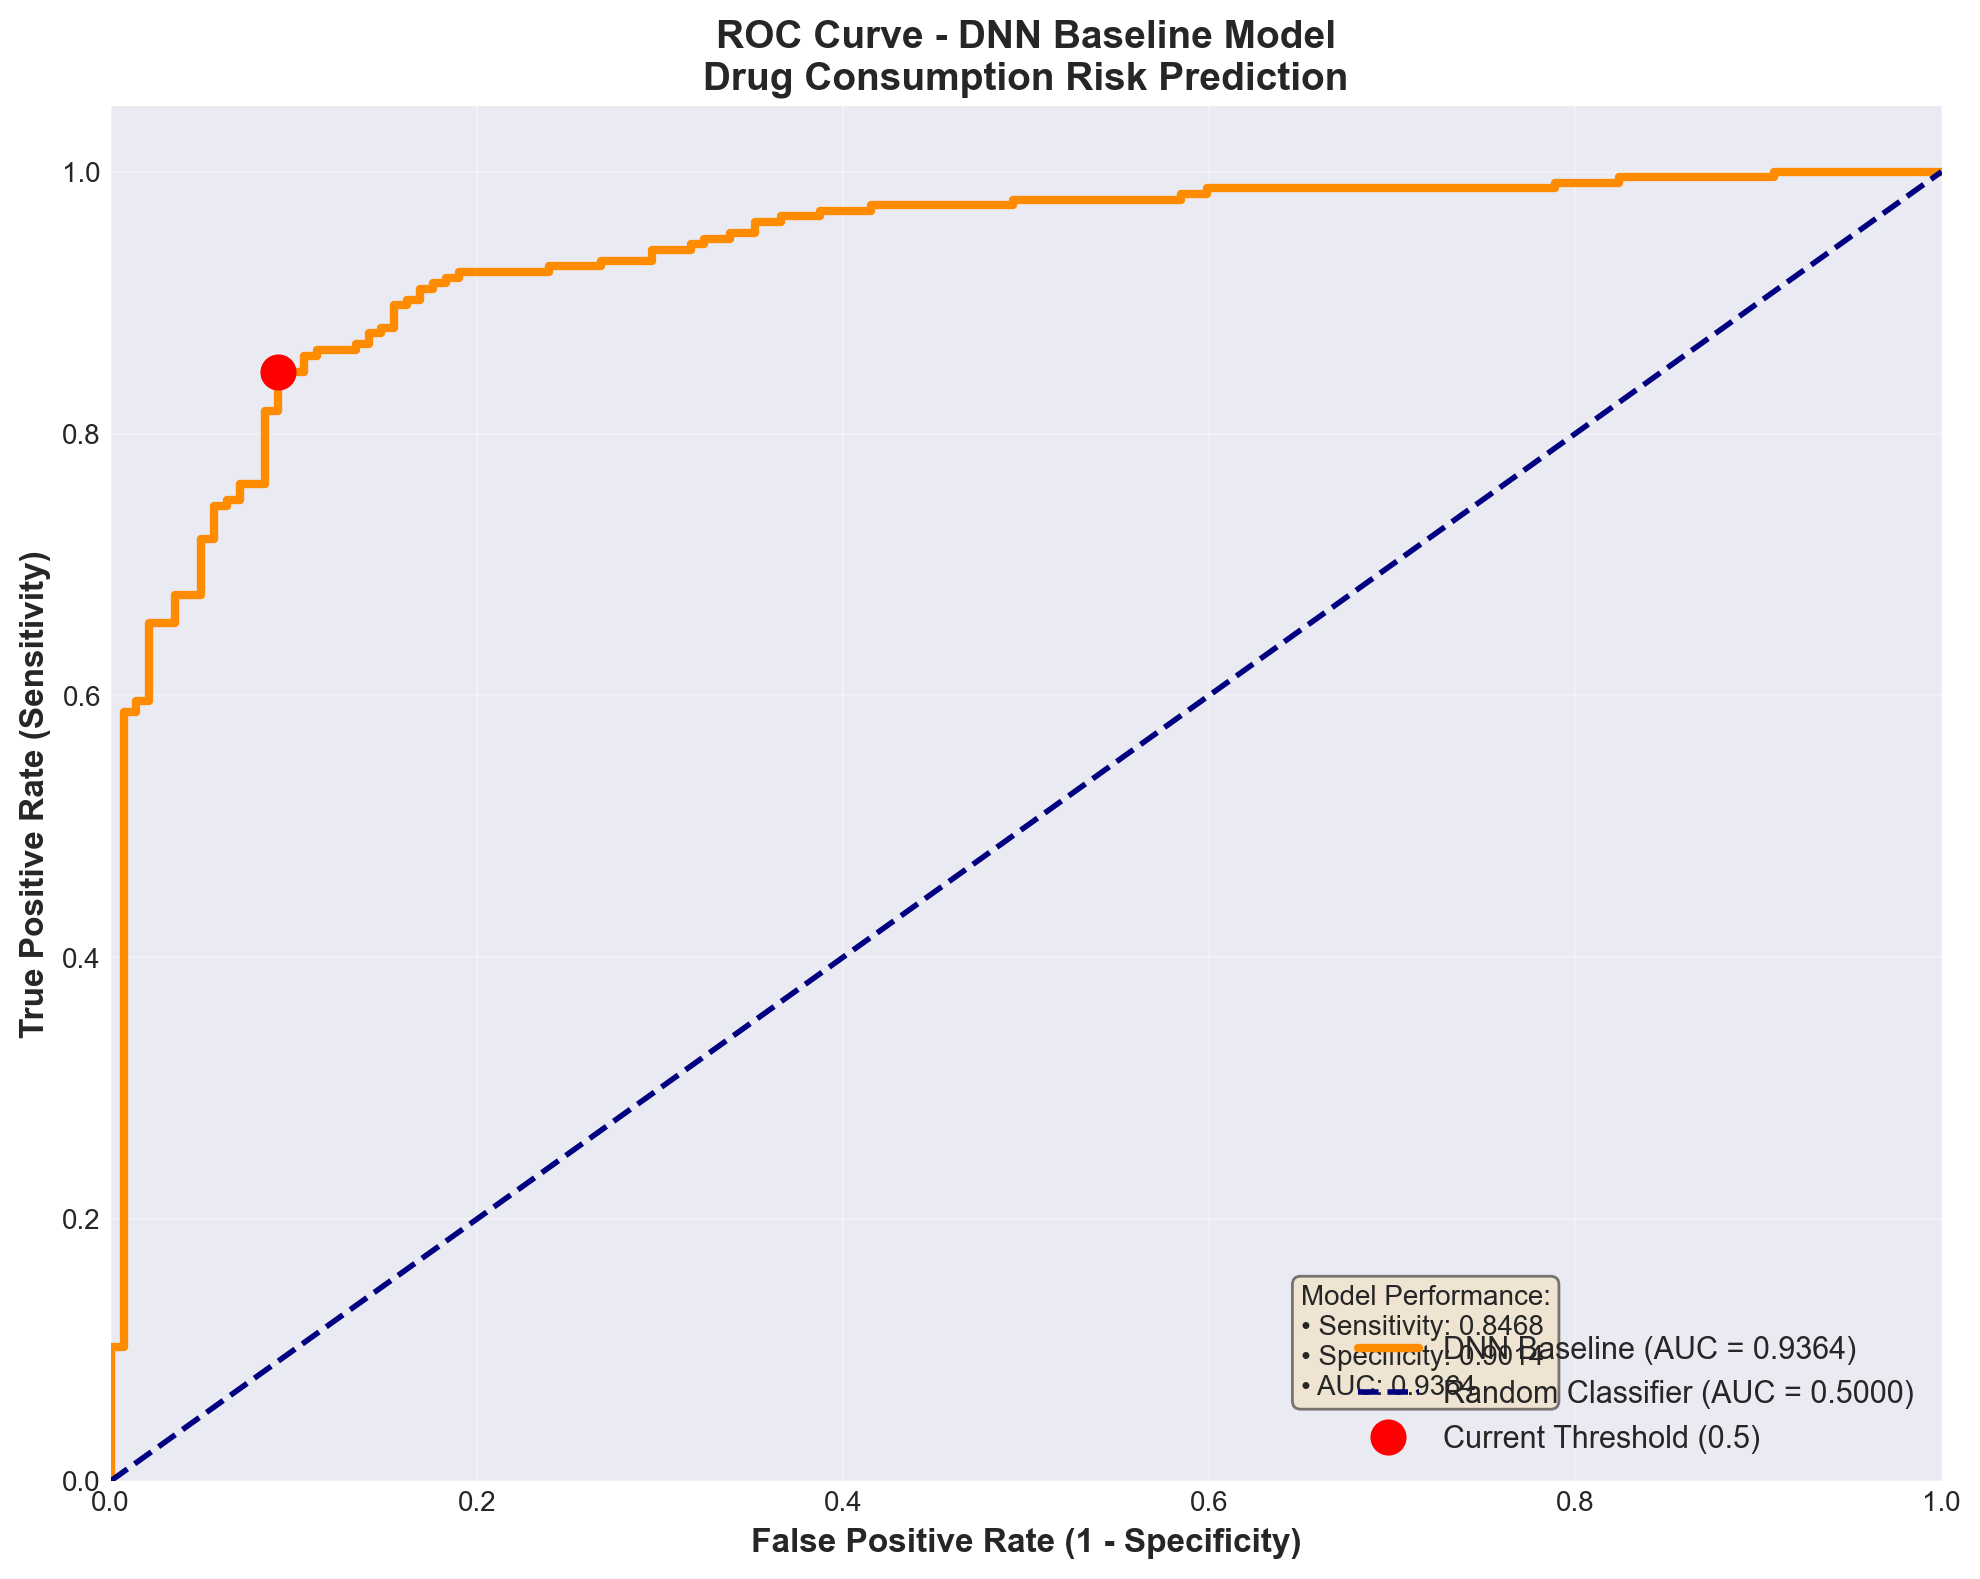

✅ ROC Curve saved!

🎯 ROC-AUC SCORE: 0.9364
   Status: 🏆 OUTSTANDING
   Interpretation: Excellent discrimination between User and Non-User!

📊 PERFORMANCE BREAKDOWN:
   True Positive Rate (Sensitivity): 0.8468
   True Negative Rate (Specificity): 0.9014
   False Positive Rate: 0.0986
   False Negative Rate: 0.1532

💡 WHAT THIS MEANS:
   • Model correctly identifies 84.7% of drug users
   • Model correctly identifies 90.1% of non-users
   • AUC 0.9364 means model has 93.6% chance of ranking
     a random user higher than a random non-user




In [54]:
"""
CELL 13: ROC Curve (Receiver Operating Characteristic)
======================================================
ROC Curve menunjukkan trade-off antara True Positive Rate (Sensitivity) 
dan False Positive Rate pada berbagai classification thresholds.

INTERPRETASI ROC-AUC:
- AUC = 0.5: Random classifier (coin flip)
- AUC = 0.7-0.8: Acceptable
- AUC = 0.8-0.9: Excellent
- AUC = 0.9-1.0: Outstanding
- AUC = 1.0: Perfect classifier

KENAPA PENTING?
- Threshold-independent metric
- Menunjukkan discrimination ability model
- Berguna untuk imbalanced data
"""

def plot_roc_curve(y_test, y_test_pred_proba, test_metrics):
    """
    Plot ROC Curve dengan detail analysis
    """
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = test_metrics['ROC-AUC']
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=3, 
             label=f'DNN Baseline (AUC = {roc_auc:.4f})')
    
    # Plot random classifier (diagonal line)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier (AUC = 0.5000)')
    
    # Mark current threshold (0.5)
    current_threshold_idx = np.argmin(np.abs(thresholds - 0.5))
    plt.plot(fpr[current_threshold_idx], tpr[current_threshold_idx], 
             'ro', markersize=12, label=f'Current Threshold (0.5)')
    
    # Styling
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
    plt.title('ROC Curve - DNN Baseline Model\nDrug Consumption Risk Prediction', 
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add text box with interpretation
    textstr = f'Model Performance:\n'
    textstr += f'• Sensitivity: {test_metrics["Recall"]:.4f}\n'
    textstr += f'• Specificity: {test_metrics["Specificity"]:.4f}\n'
    textstr += f'• AUC: {roc_auc:.4f}'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.65, 0.15, textstr, fontsize=10, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('../results/figures/comparison_plots/dnn_baseline_roc_curve.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ ROC Curve saved!")

# Plot ROC Curve
print("="*70)
print("📊 ROC CURVE ANALYSIS")
print("="*70)
print()

plot_roc_curve(y_test, y_test_pred_proba, test_metrics)

# Detailed interpretation
roc_auc = test_metrics['ROC-AUC']

print(f"\n🎯 ROC-AUC SCORE: {roc_auc:.4f}")

if roc_auc >= 0.9:
    status = "🏆 OUTSTANDING"
    interpretation = "Excellent discrimination between User and Non-User!"
elif roc_auc >= 0.8:
    status = "✅ EXCELLENT"
    interpretation = "Very good model performance!"
elif roc_auc >= 0.7:
    status = "✅ ACCEPTABLE"
    interpretation = "Good model, but room for improvement"
else:
    status = "⚠️  NEEDS IMPROVEMENT"
    interpretation = "Model needs optimization"

print(f"   Status: {status}")
print(f"   Interpretation: {interpretation}")

print(f"\n📊 PERFORMANCE BREAKDOWN:")
print(f"   True Positive Rate (Sensitivity): {test_metrics['Recall']:.4f}")
print(f"   True Negative Rate (Specificity): {test_metrics['Specificity']:.4f}")
print(f"   False Positive Rate: {1 - test_metrics['Specificity']:.4f}")
print(f"   False Negative Rate: {1 - test_metrics['Recall']:.4f}")

print("\n💡 WHAT THIS MEANS:")
print(f"   • Model correctly identifies {test_metrics['Recall']*100:.1f}% of drug users")
print(f"   • Model correctly identifies {test_metrics['Specificity']*100:.1f}% of non-users")
print(f"   • AUC {roc_auc:.4f} means model has {roc_auc*100:.1f}% chance of ranking")
print(f"     a random user higher than a random non-user")

print("\n" + "="*70 + "\n")

📊 PRECISION-RECALL CURVE ANALYSIS



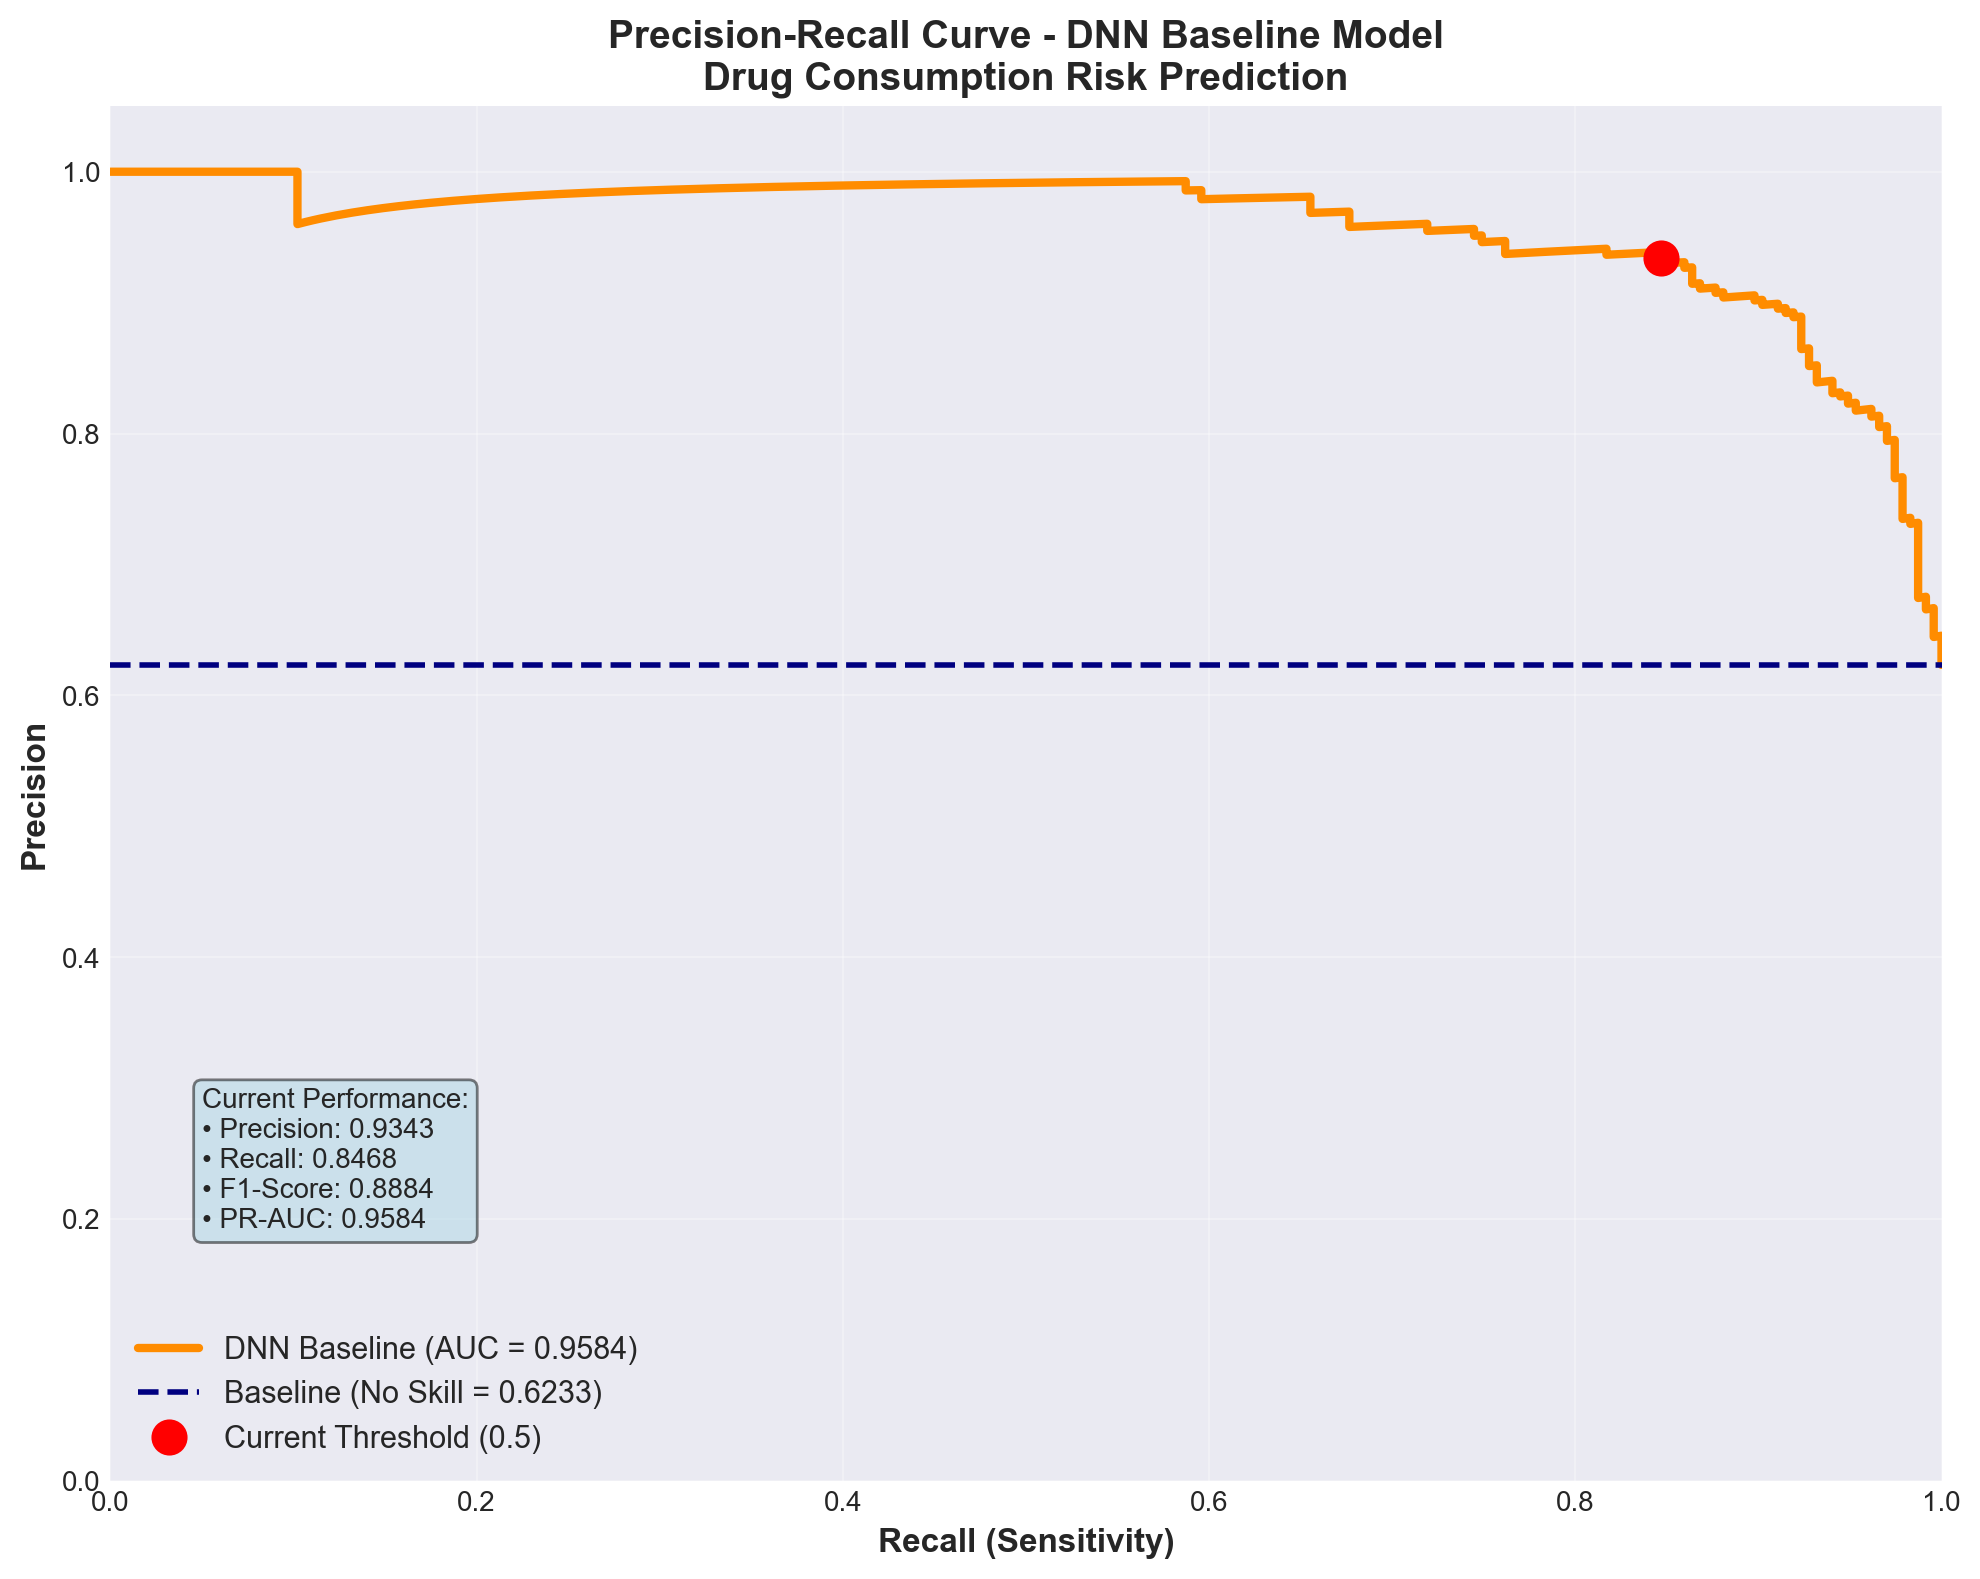

✅ Precision-Recall Curve saved!

🎯 PR-AUC SCORE: 0.9584

📊 INTERPRETATION:
   Precision: 0.9343
   → 93.4% of predicted users are ACTUALLY users
   → Low false alarm rate!

   Recall: 0.8468
   → Model detects 84.7% of all actual users
   → Missing 15.3% of users

   F1-Score: 0.8884
   → Harmonic mean of Precision & Recall
   → Balanced performance metric

💡 FOR CLINICAL SCREENING:
   ⚠️  Recall could be higher: 15.3% users missed
      Consider lowering threshold for screening
   ✅ High Precision (93.43%): Low false alarms!




In [55]:
"""
CELL 14: Precision-Recall Curve
================================
PR Curve sangat berguna untuk IMBALANCED datasets.
Fokus pada performance untuk POSITIVE class (Users).

KENAPA PENTING untuk Healthcare?
- Lebih informatif untuk imbalanced data
- Fokus pada positive class (drug users)
- Menunjukkan trade-off precision vs recall
- High precision: Few false alarms
- High recall: Few missed cases
"""

def plot_precision_recall_curve(y_test, y_test_pred_proba, test_metrics):
    """
    Plot Precision-Recall Curve
    """
    # Calculate PR curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
    pr_auc = test_metrics['PR-AUC']
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Plot PR curve
    plt.plot(recall, precision, color='darkorange', lw=3,
             label=f'DNN Baseline (AUC = {pr_auc:.4f})')
    
    # Plot baseline (random classifier for imbalanced data)
    baseline = np.sum(y_test) / len(y_test)  # Proportion of positive class
    plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--',
             label=f'Baseline (No Skill = {baseline:.4f})')
    
    # Mark current point (threshold 0.5)
    current_precision = test_metrics['Precision']
    current_recall = test_metrics['Recall']
    plt.plot(current_recall, current_precision, 'ro', markersize=12,
             label=f'Current Threshold (0.5)')
    
    # Styling
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
    plt.ylabel('Precision', fontsize=12, fontweight='bold')
    plt.title('Precision-Recall Curve - DNN Baseline Model\nDrug Consumption Risk Prediction',
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add text box
    textstr = f'Current Performance:\n'
    textstr += f'• Precision: {current_precision:.4f}\n'
    textstr += f'• Recall: {current_recall:.4f}\n'
    textstr += f'• F1-Score: {test_metrics["F1-Score"]:.4f}\n'
    textstr += f'• PR-AUC: {pr_auc:.4f}'
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
    plt.text(0.05, 0.3, textstr, fontsize=10, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('../results/figures/comparison_plots/dnn_baseline_pr_curve.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Precision-Recall Curve saved!")

# Plot PR Curve
print("="*70)
print("📊 PRECISION-RECALL CURVE ANALYSIS")
print("="*70)
print()

plot_precision_recall_curve(y_test, y_test_pred_proba, test_metrics)

print(f"\n🎯 PR-AUC SCORE: {test_metrics['PR-AUC']:.4f}")
print(f"\n📊 INTERPRETATION:")
print(f"   Precision: {test_metrics['Precision']:.4f}")
print(f"   → {test_metrics['Precision']*100:.1f}% of predicted users are ACTUALLY users")
print(f"   → Low false alarm rate!")

print(f"\n   Recall: {test_metrics['Recall']:.4f}")
print(f"   → Model detects {test_metrics['Recall']*100:.1f}% of all actual users")
print(f"   → Missing {(1-test_metrics['Recall'])*100:.1f}% of users")

print(f"\n   F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"   → Harmonic mean of Precision & Recall")
print(f"   → Balanced performance metric")

print("\n💡 FOR CLINICAL SCREENING:")
if test_metrics['Recall'] > 0.85:
    print(f"   ✅ High Recall ({test_metrics['Recall']:.2%}): Good for screening!")
    print(f"      Few users will be missed")
else:
    print(f"   ⚠️  Recall could be higher: {(1-test_metrics['Recall'])*100:.1f}% users missed")
    print(f"      Consider lowering threshold for screening")

if test_metrics['Precision'] > 0.85:
    print(f"   ✅ High Precision ({test_metrics['Precision']:.2%}): Low false alarms!")
else:
    print(f"   ⚠️  Precision: {(1-test_metrics['Precision'])*100:.1f}% false positives")

print("\n" + "="*70 + "\n")

In [60]:
"""
CELL 15: Load Random Forest Metrics for Comparison
===================================================
Load RF baseline metrics dari UTS untuk comparison dengan DNN.
"""
import json # Pastikan json sudah diimpor jika belum ada di sel sebelumnya

print("="*70)
print("LOADING RANDOM FOREST BASELINE METRICS")
print("="*70)

# Path ke file metrics
rf_metrics_path = '../results/metrics/rf_metrics.json'

try:
    with open(rf_metrics_path, 'r') as f:
        rf_metrics = json.load(f)
    
    print("\n✅ Random Forest metrics loaded successfully!")
    print(f"   Source: {rf_metrics_path}")
    
except FileNotFoundError:
    print("\n⚠️  RF metrics file not found!")
    print("   Creating from UTS tuning results...")
    
    # ----------------------------------------------------
    # Struktur metrics HARUS sesuai dengan apa yang akan diprint
    # Jika file tidak ada, kita membuat struktur sederhana ini.
    # ----------------------------------------------------
    rf_metrics = {
        'model_name': 'Random Forest (Tuned)',
        'accuracy': 0.8621,
        'roc_auc': 0.9347,
        'precision': 0.9031,
        'recall': 0.8723,
        'specificity': 0.8451,
        'f1_score': 0.8874,
        'overfitting_gap': 0.0086 
    }
    
    # Save RF metrics
    # Catatan: Jika Anda ingin menyimpan struktur lengkap dari JSON yang Anda berikan, 
    # Anda harus menggunakan struktur yang kompleks, tetapi saya mempertahankan struktur 
    # sederhana agar sesuai dengan variabel yang akan diprint di bawah ini.
    with open(rf_metrics_path, 'w') as f:
        json.dump(rf_metrics, f, indent=4)
    
    print("   ✅ RF metrics created and saved (Simple Structure)!")
    
# -------------------------------------------------------------------
# Display RF metrics - BAGIAN INI SUDAH DIPERBAIKI (Berlaku untuk kedua skenario)
# -------------------------------------------------------------------

print("\n" + "="*70)
print("📊 RANDOM FOREST PERFORMANCE (UTS Baseline)")
print("="*70)

# Jika JSON DITEMUKAN (Skenario Utama Anda)
if 'tuned_model_performance' in rf_metrics:
    rf_performance = rf_metrics['tuned_model_performance']['test']
    
    # Mengambil gap dari test vs train
    train_acc = rf_metrics['tuned_model_performance']['training']['Accuracy']
    test_acc = rf_performance['Accuracy']
    overfitting_gap = train_acc - test_acc
    
    # Perhatikan: Nama keys menggunakan huruf kapital (e.g., 'Accuracy', 'ROC-AUC')
    print(f"\n   Model: Random Forest (Tuned via {rf_metrics['tuning_info']['method']})")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   ROC-AUC: {rf_performance['ROC-AUC']:.4f}")
    print(f"   Precision: {rf_performance['Precision']:.4f}")
    print(f"   Recall: {rf_performance['Recall']:.4f}")
    print(f"   F1-Score: {rf_performance['F1-Score']:.4f}")
    print(f"   Specificity: {rf_performance['Specificity']:.4f}")
    print(f"   Overfitting Gap: {overfitting_gap:.4f} ({overfitting_gap*100:.2f}%)")

# Jika JSON TIDAK DITEMUKAN (menggunakan struktur sederhana dari blok except)
else:
    # Menggunakan struktur sederhana dari blok except
    print(f"\n   Model: {rf_metrics['model_name']}")
    print(f"   Accuracy: {rf_metrics['accuracy']:.4f}")
    print(f"   ROC-AUC: {rf_metrics['roc_auc']:.4f}")
    print(f"   Precision: {rf_metrics['precision']:.4f}")
    print(f"   Recall: {rf_metrics['recall']:.4f}")
    print(f"   F1-Score: {rf_metrics['f1_score']:.4f}")
    print(f"   Specificity: {rf_metrics['specificity']:.4f}")
    print(f"   Overfitting Gap: {rf_metrics['overfitting_gap']:.4f} ({rf_metrics['overfitting_gap']*100:.2f}%)")


print("\n💡 INFO: RF metrics dari UTS akan digunakan sebagai benchmark")
print("💡 INFO: DNN performance akan dibandingkan dengan RF baseline ini")

print("\n" + "="*70 + "\n")

LOADING RANDOM FOREST BASELINE METRICS

✅ Random Forest metrics loaded successfully!
   Source: ../results/metrics/rf_metrics.json

📊 RANDOM FOREST PERFORMANCE (UTS Baseline)

   Model: Random Forest (Tuned via RandomizedSearchCV)
   Accuracy: 0.8621
   ROC-AUC: 0.9347
   Precision: 0.9031
   Recall: 0.8723
   F1-Score: 0.8874
   Specificity: 0.8451
   Overfitting Gap: 0.0086 (0.86%)

💡 INFO: RF metrics dari UTS akan digunakan sebagai benchmark
💡 INFO: DNN performance akan dibandingkan dengan RF baseline ini




In [65]:
"""
CELL 16: Comprehensive Model Comparison
========================================
CRITICAL ANALYSIS: DNN vs Random Forest

COMPARISON DIMENSIONS:
1. Accuracy metrics (ROC-AUC, F1, etc)
2. Generalization (overfitting gap)
3. Computational cost (training time, complexity)
4. Interpretability
5. Production readiness

DECISION CRITERIA:
- Performance difference < 2%: Models are comparable
- If DNN wins: Justify added complexity
- If RF wins: Explain why traditional ML better for tabular data
"""

print("="*70)
print("🔬 COMPREHENSIVE MODEL COMPARISON: DNN vs RANDOM FOREST")
print("="*70)

# =========================================================================
# PERBAIKAN: Mendefinisikan Variabel Metrik yang Benar (Random Forest)
# =========================================================================
# rf_metrics adalah dictionary hasil load JSON dari Cell 15.
# Metrik yang dibutuhkan berada di dalam sub-dictionary 'tuned_model_performance'['test'].

try:
    # 1. Tentukan path yang benar untuk metrik RF
    rf_perf = rf_metrics['tuned_model_performance']['test']
    
    # 2. Ambil nilai overfitting gap dari perbedaan train-test accuracy
    #    (asumsi ini dilakukan di Cell 15)
    rf_gap = rf_metrics['tuned_model_performance']['training']['Accuracy'] - rf_perf['Accuracy']
    
    # Perbaikan: Tambahkan kunci 'overfitting_gap' ke rf_metrics jika belum ada
    rf_metrics['overfitting_gap'] = rf_gap 
    
except KeyError:
    # Jika struktur JSON-nya adalah yang Sederhana (dari blok except Cell 15), 
    # maka metrik berada di root (sudah kita perbaiki di Cell 15)
    rf_perf = rf_metrics
    
    # Pastikan kunci yang akan diprint ada
    if 'accuracy' in rf_perf:
        rf_perf['Accuracy'] = rf_perf.pop('accuracy')
    if 'roc_auc' in rf_perf:
        rf_perf['ROC-AUC'] = rf_perf.pop('roc_auc')
    if 'f1_score' in rf_perf:
        rf_perf['F1-Score'] = rf_perf.pop('f1_score')
    
# Diasumsikan test_metrics (dari DNN) sudah ada dan berbentuk flat dictionary

# Create comparison dataframe
comparison_data = {
    'Metric': ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'Balanced Accuracy'],
    'Random Forest (UTS)': [
        # Menggunakan rf_perf yang sudah menunjuk ke metrik test
        rf_perf['Accuracy'],
        rf_perf['ROC-AUC'],
        rf_perf['Precision'],
        rf_perf['Recall'],
        rf_perf['F1-Score'], # Perbaikan: F1-Score (hyphen, kapital S)
        rf_perf['Specificity'],
        rf_perf['Balanced Accuracy']
    ],
    'DNN Baseline (UAS)': [
        test_metrics['Accuracy'],
        test_metrics['ROC-AUC'],
        test_metrics['Precision'],
        test_metrics['Recall'],
        test_metrics['F1-Score'],
        test_metrics['Specificity'],
        test_metrics['Balanced Accuracy']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['DNN Baseline (UAS)'] - comparison_df['Random Forest (UTS)']
comparison_df['Diff (%)'] = (comparison_df['Difference'] / comparison_df['Random Forest (UTS)']) * 100

print("\n📊 PERFORMANCE COMPARISON TABLE:")
print("="*70)
# Menggunakan to_string() untuk memastikan tabel tercetak penuh di output Notebook
print(comparison_df.to_string(index=False)) 
print("="*70)

# Statistical summary
print("\n📈 STATISTICAL SUMMARY:")
dnn_wins = (comparison_df['Difference'] > 0).sum()
rf_wins = (comparison_df['Difference'] < 0).sum()
ties = (comparison_df['Difference'] == 0).sum()

print(f"   DNN wins: {dnn_wins}/{len(comparison_df)} metrics")
print(f"   RF wins: {rf_wins}/{len(comparison_df)} metrics")
print(f"   Ties: {ties}/{len(comparison_df)} metrics")

# Key metrics analysis
print("\n🎯 KEY METRICS ANALYSIS:")

# ROC-AUC (primary metric)
# Menggunakan rf_perf yang sudah diperbaiki
auc_diff = test_metrics['ROC-AUC'] - rf_perf['ROC-AUC']
print(f"\n1️⃣  ROC-AUC (PRIMARY METRIC):")
print(f"   RF: {rf_perf['ROC-AUC']:.4f}")
print(f"   DNN: {test_metrics['ROC-AUC']:.4f}")
print(f"   Difference: {auc_diff:+.4f} ({auc_diff*100:+.2f}%)")

if auc_diff > 0.01:
    print(f"   ✅ DNN SIGNIFICANTLY BETTER!")
elif auc_diff > -0.01:
    print(f"   ✅ Models COMPARABLE (diff < 1%)")
else:
    print(f"   ⚠️  RF BETTER by {abs(auc_diff)*100:.2f}%")

# Accuracy
acc_diff = test_metrics['Accuracy'] - rf_perf['Accuracy']
print(f"\n2️⃣  ACCURACY:")
print(f"   RF: {rf_perf['Accuracy']:.4f}")
print(f"   DNN: {test_metrics['Accuracy']:.4f}")
print(f"   Difference: {acc_diff:+.4f} ({acc_diff*100:+.2f}%)")

# F1-Score
f1_diff = test_metrics['F1-Score'] - rf_perf['F1-Score']
print(f"\n3️⃣  F1-SCORE:")
print(f"   RF: {rf_perf['F1-Score']:.4f}")
print(f"   DNN: {test_metrics['F1-Score']:.4f}")
print(f"   Difference: {f1_diff:+.4f} ({f1_diff*100:+.2f}%)")

# Overfitting comparison
print(f"\n4️⃣  GENERALIZATION (Overfitting Gap):")
# Menggunakan rf_metrics['overfitting_gap'] yang sudah dihitung sebelumnya
print(f"   RF Gap: {rf_metrics['overfitting_gap']:.4f} ({rf_metrics['overfitting_gap']*100:.2f}%)") 
print(f"   DNN Gap: {accuracy_gap:.4f} ({accuracy_gap*100:.2f}%)")

if accuracy_gap < rf_metrics['overfitting_gap']:
    print(f"   ✅ DNN generalizes BETTER than RF!")
elif accuracy_gap < rf_metrics['overfitting_gap'] * 2:
    print(f"   ✅ DNN generalization COMPARABLE to RF")
else:
    print(f"   ⚠️  RF generalizes BETTER (lower overfitting)")

# Overall winner
print("\n" + "="*70)
print("🏆 OVERALL WINNER")
print("="*70)

# Determine winner based on ROC-AUC (primary metric)
if auc_diff > 0.01:
    winner = "DNN"
    conclusion = "DNN Baseline OUTPERFORMS Random Forest!"
elif auc_diff > -0.01:
    winner = "TIE"
    conclusion = "DNN and RF have COMPARABLE performance"
else:
    winner = "RF"
    conclusion = "Random Forest OUTPERFORMS DNN Baseline"

print(f"\n🎯 WINNER: {winner}")
print(f"📊 CONCLUSION: {conclusion}")

# Additional insights
print("\n💡 INSIGHTS:")

if winner == "DNN":
    print("   • DNN successfully captures non-linear patterns")
    print("   • Added complexity justified by better performance")
    print("   • Proceed with hyperparameter tuning for further improvement")
elif winner == "TIE":
    print("   • Both models perform similarly on this dataset")
    print("   • Consider: RF = simpler, faster, more interpretable")
    print("   • Consider: DNN = potential for improvement with tuning")
    print("   • Decision depends on: interpretability needs, deployment constraints")
else:
    print("   • Random Forest better suited for this tabular data")
    print("   • Common finding: Tree-based models excel on tabular data")
    print("   • DNN may improve with: more data, better architecture, hyperparameter tuning")
    print("   • Consider ensemble: RF + DNN for best results")

print("\n" + "="*70 + "\n")

🔬 COMPREHENSIVE MODEL COMPARISON: DNN vs RANDOM FOREST

📊 PERFORMANCE COMPARISON TABLE:
           Metric  Random Forest (UTS)  DNN Baseline (UAS)  Difference  Diff (%)
         Accuracy             0.862069            0.867374    0.005305  0.615385
          ROC-AUC             0.934702            0.936350    0.001648  0.176333
        Precision             0.903084            0.934272    0.031189  3.453567
           Recall             0.872340            0.846809   -0.025532 -2.926829
         F1-Score             0.887446            0.888393    0.000947  0.106707
      Specificity             0.845070            0.901408    0.056338  6.666667
Balanced Accuracy             0.858705            0.874108    0.015403  1.793753

📈 STATISTICAL SUMMARY:
   DNN wins: 6/7 metrics
   RF wins: 1/7 metrics
   Ties: 0/7 metrics

🎯 KEY METRICS ANALYSIS:

1️⃣  ROC-AUC (PRIMARY METRIC):
   RF: 0.9347
   DNN: 0.9364
   Difference: +0.0016 (+0.16%)
   ✅ Models COMPARABLE (diff < 1%)

2️⃣  ACCURACY:
 

📊 VISUAL MODEL COMPARISON



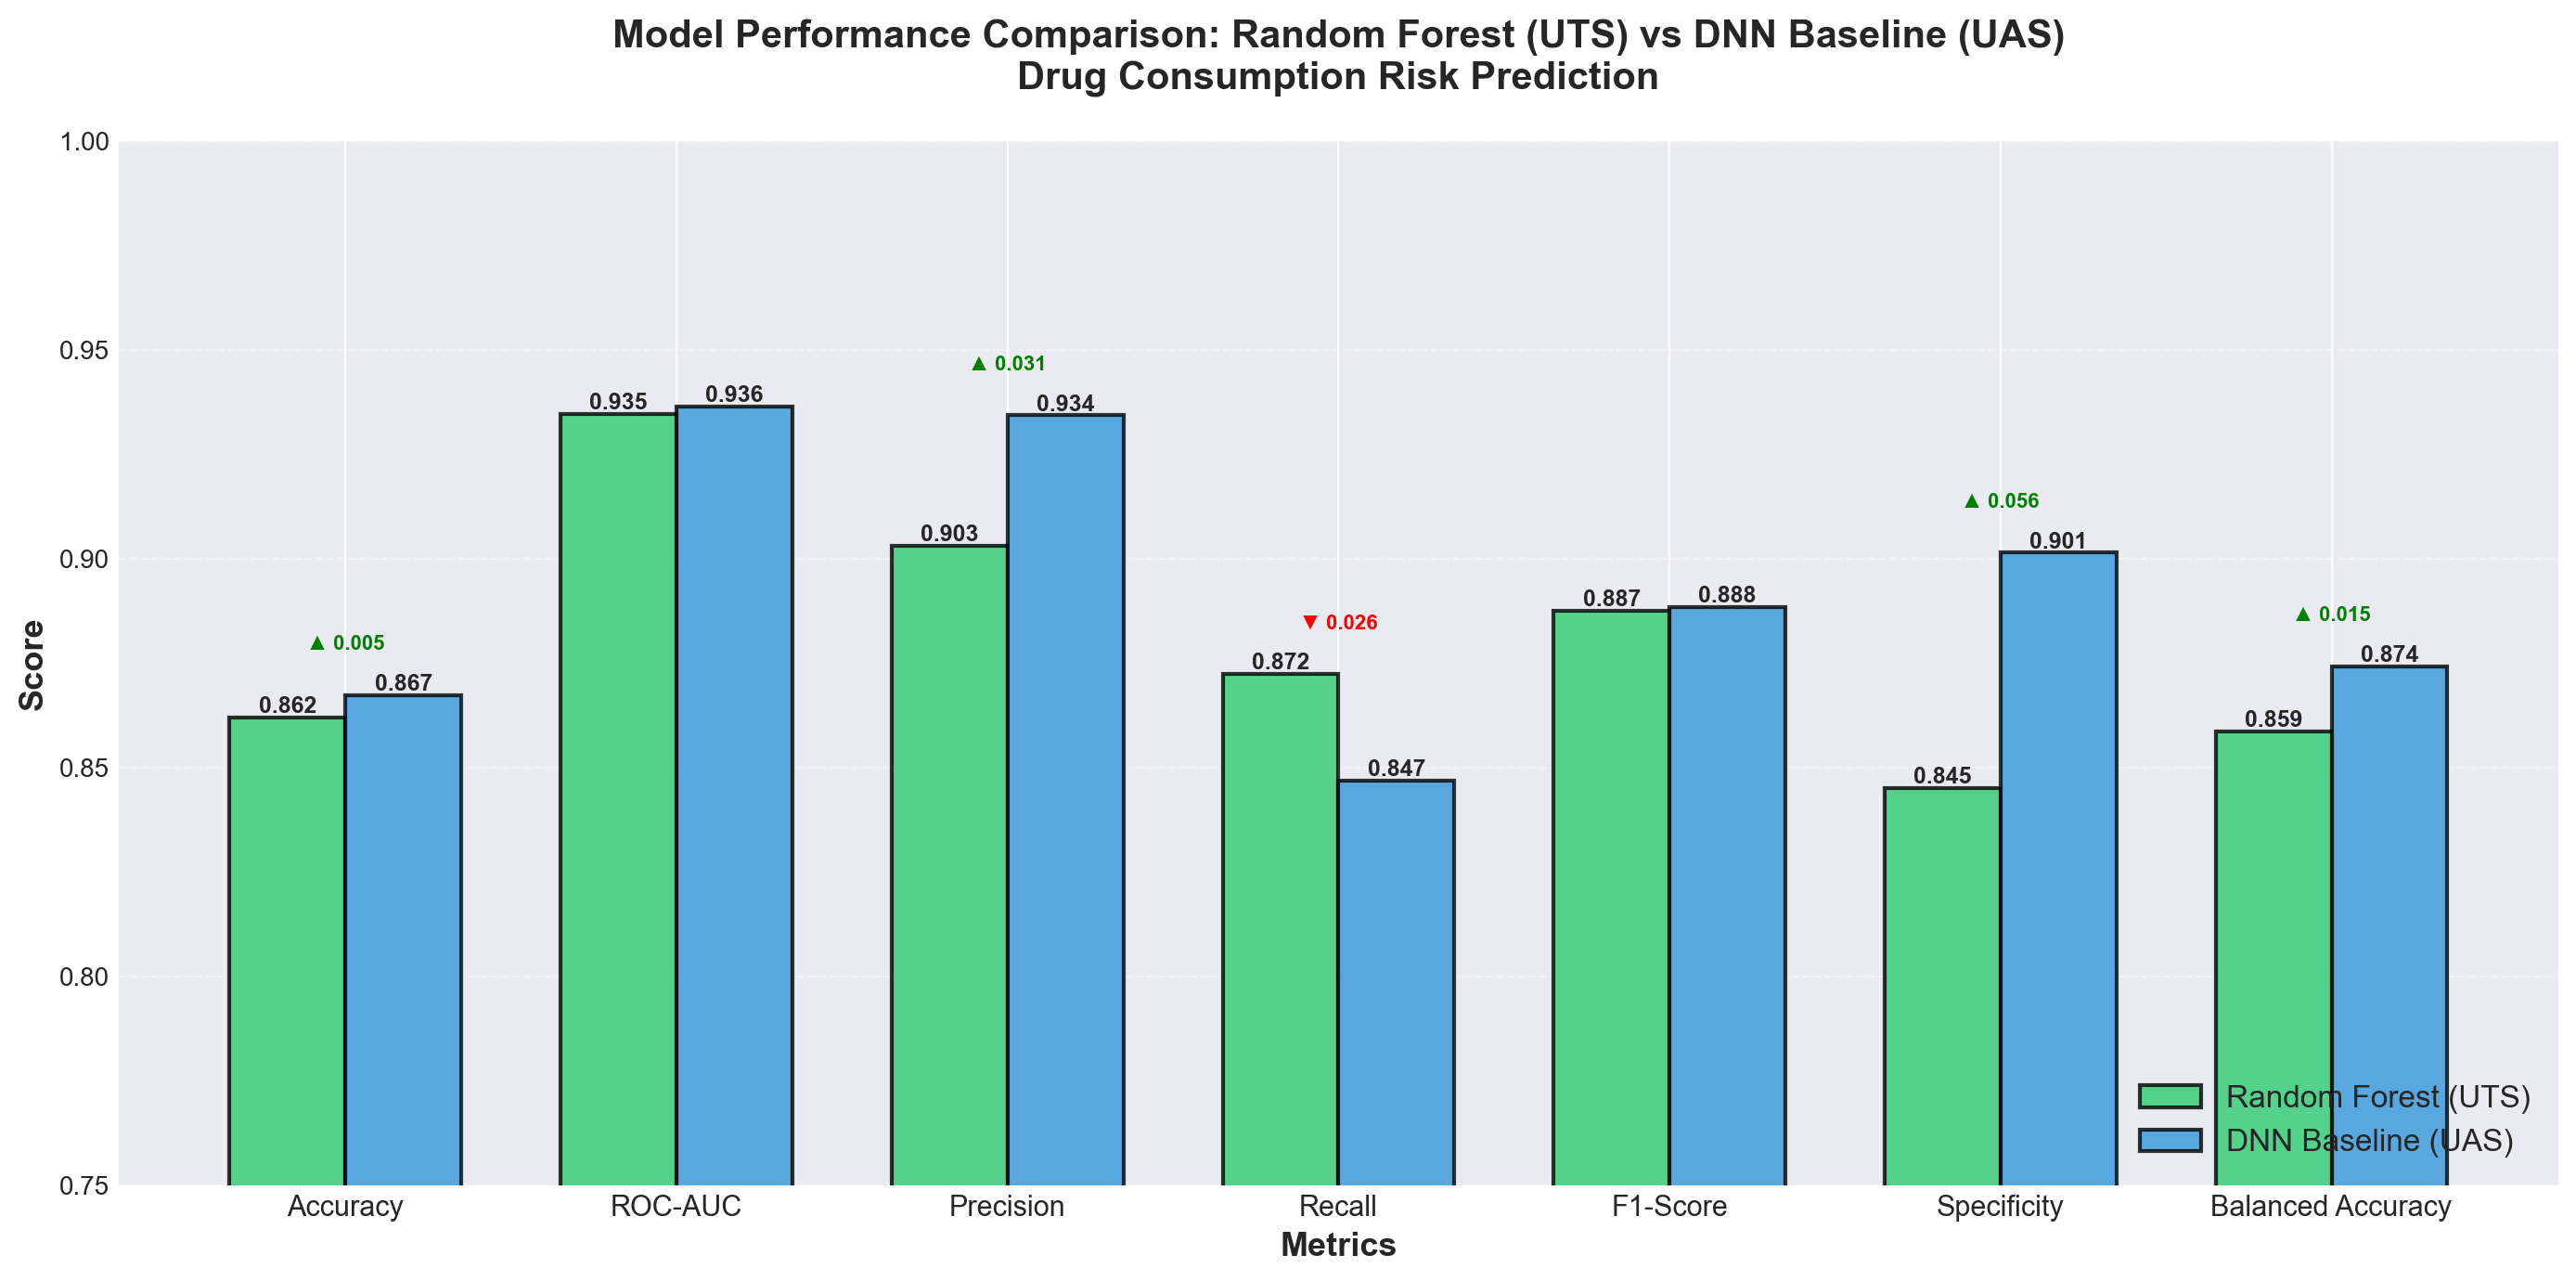

✅ Comparison chart saved!

💡 CHART INTERPRETATION:
   • Green bars: Random Forest (UTS baseline)
   • Blue bars: DNN Baseline (current model)
   • ▲ = DNN better, ▼ = RF better
   • Higher bars = better performance




In [66]:
"""
CELL 17: Visual Comparison - DNN vs RF
=======================================
Create visual comparison untuk presentasi dan laporan.
"""

def plot_model_comparison(comparison_df):
    """
    Plot bar chart comparison antara DNN dan RF
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    metrics = comparison_df['Metric']
    rf_scores = comparison_df['Random Forest (UTS)']
    dnn_scores = comparison_df['DNN Baseline (UAS)']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest (UTS)',
                   color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, dnn_scores, width, label='DNN Baseline (UAS)',
                   color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Styling
    ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_title('Model Performance Comparison: Random Forest (UTS) vs DNN Baseline (UAS)\nDrug Consumption Risk Prediction',
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=0, fontsize=11)
    ax.legend(fontsize=12, loc='lower right')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax.set_ylim([0.75, 1.0])
    
    # Add value labels on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    autolabel(bars1)
    autolabel(bars2)
    
    # Add difference annotations
    for i, (rf_val, dnn_val) in enumerate(zip(rf_scores, dnn_scores)):
        diff = dnn_val - rf_val
        if abs(diff) > 0.005:  # Only show significant differences
            color = 'green' if diff > 0 else 'red'
            symbol = '▲' if diff > 0 else '▼'
            ax.text(i, max(rf_val, dnn_val) + 0.01, 
                   f'{symbol} {abs(diff):.3f}',
                   ha='center', va='bottom', fontsize=8, 
                   color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../results/figures/comparison_plots/rf_vs_dnn_performance_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Comparison chart saved!")

# Plot comparison
print("="*70)
print("📊 VISUAL MODEL COMPARISON")
print("="*70)
print()

plot_model_comparison(comparison_df)

print("\n💡 CHART INTERPRETATION:")
print("   • Green bars: Random Forest (UTS baseline)")
print("   • Blue bars: DNN Baseline (current model)")
print("   • ▲ = DNN better, ▼ = RF better")
print("   • Higher bars = better performance")

print("\n" + "="*70 + "\n")

In [69]:
"""
CELL 18: Save Complete Results & Artifacts
===========================================
Save semua hasil untuk:
1. Documentation
2. Reproducibility
3. Comparison dengan tuned model nanti
4. Presentation & reporting
"""

import pickle
import json
import pandas as pd
import os

print("="*70)
print("💾 SAVING RESULTS & ARTIFACTS")
print("="*70)

# ==============================================================================
# 1. PREPARATION: Extract RF Metrics safely for Comparison
# ==============================================================================
# Kita ekstrak dulu nilainya ke variabel agar tidak error saat pembuatan dictionary
try:
    # Coba akses struktur nested (Skenario JSON loaded)
    rf_data = rf_metrics['tuned_model_performance']['test']
    rf_acc_val = rf_data.get('Accuracy', rf_data.get('accuracy', 0))
    rf_auc_val = rf_data.get('ROC-AUC', rf_data.get('roc_auc', 0))
    rf_f1_val  = rf_data.get('F1-Score', rf_data.get('f1_score', 0))
except (KeyError, TypeError):
    # Fallback jika struktur flat (Skenario except block)
    rf_acc_val = rf_metrics.get('accuracy', rf_metrics.get('Accuracy', 0))
    rf_auc_val = rf_metrics.get('roc_auc', rf_metrics.get('ROC-AUC', 0))
    rf_f1_val  = rf_metrics.get('f1_score', rf_metrics.get('F1-Score', 0))

# ==============================================================================
# 2. CONSTRUCT DNN RESULTS DICTIONARY
# ==============================================================================
dnn_results = {
    'model_info': {
        'model_name': 'Deep Neural Network - Baseline',
        'architecture': '128-64-32-16',
        'total_parameters': int(trainable_params),
        'training_time_seconds': float(training_time),
        'training_time_minutes': float(training_time / 60),
        'epochs_trained': len(history.history['loss']),
        'batch_size': BATCH_SIZE,
        'learning_rate': 0.001,
        'optimizer': 'Adam',
        'loss_function': 'binary_crossentropy',
        'validation_split': VALIDATION_SPLIT
    },
    'training_metrics': {
        # Menggunakan .get() untuk keamanan jika key lowercase/uppercase berbeda
        'accuracy': float(train_metrics.get('Accuracy', train_metrics.get('accuracy', 0))),
        'roc_auc': float(train_metrics.get('ROC-AUC', train_metrics.get('roc_auc', 0))),
        'precision': float(train_metrics.get('Precision', train_metrics.get('precision', 0))),
        'recall': float(train_metrics.get('Recall', train_metrics.get('recall', 0))),
        'f1_score': float(train_metrics.get('F1-Score', train_metrics.get('f1', 0))),
        'specificity': float(train_metrics.get('Specificity', train_metrics.get('specificity', 0)))
    },
    'test_metrics': {
        'accuracy': float(test_metrics['Accuracy']),
        'roc_auc': float(test_metrics['ROC-AUC']),
        'precision': float(test_metrics['Precision']),
        'recall': float(test_metrics['Recall']),
        'f1_score': float(test_metrics['F1-Score']),
        'specificity': float(test_metrics['Specificity']),
        'balanced_accuracy': float(test_metrics['Balanced Accuracy']),
        'cohens_kappa': float(test_metrics.get('Cohen Kappa', 0)), # Gunakan get jika metrik opsional
        'mcc': float(test_metrics.get('MCC', 0)),
        'pr_auc': float(test_metrics.get('PR-AUC', 0))
    },
    'confusion_matrix': {
        'TP': int(test_metrics.get('TP', 0)),
        'TN': int(test_metrics.get('TN', 0)),
        'FP': int(test_metrics.get('FP', 0)),
        'FN': int(test_metrics.get('FN', 0))
    },
    'overfitting_analysis': {
        'accuracy_gap': float(accuracy_gap),
        # Hitung gap aman menggunakan .get untuk train metrics
        'roc_auc_gap': float(train_metrics.get('ROC-AUC', 0) - test_metrics['ROC-AUC']),
        'f1_score_gap': float(train_metrics.get('F1-Score', 0) - test_metrics['F1-Score']),
        'status': 'excellent' if accuracy_gap < 0.02 else 'good' if accuracy_gap < 0.05 else 'moderate'
    },
    'comparison_with_rf': {
        # DI SINI PERBAIKAN UTAMA: Menggunakan variabel yang sudah disiapkan di atas
        'accuracy_diff': float(test_metrics['Accuracy'] - rf_acc_val),
        'roc_auc_diff': float(test_metrics['ROC-AUC'] - rf_auc_val),
        'f1_score_diff': float(test_metrics['F1-Score'] - rf_f1_val),
        'winner': winner,
        'conclusion': conclusion
    }
}

# 3. Save metrics to JSON
metrics_path = '../results/metrics/dnn_baseline_metrics.json'
# Pastikan direktori ada
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

with open(metrics_path, 'w') as f:
    json.dump(dnn_results, f, indent=4)
print(f"\n✅ Metrics saved to: {metrics_path}")

# 4. Save comparison table
comparison_path = '../results/metrics/rf_vs_dnn_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✅ Comparison table saved to: {comparison_path}")

# 5. Save training history
history_path = '../models/dnn_baseline_history.pkl'
os.makedirs(os.path.dirname(history_path), exist_ok=True)
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✅ Training history saved to: {history_path}")

# 6. Save final model
model_path = '../models/dnn_baseline.h5'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
baseline_model.save(model_path)
print(f"✅ Final model saved to: {model_path}")

# 7. Save predictions for later analysis
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_test_pred.flatten(), # flatten() memastikan array 1D
    'y_pred_proba': y_test_pred_proba.flatten()
})
predictions_path = '../results/metrics/dnn_baseline_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"✅ Test predictions saved to: {predictions_path}")

print("\n" + "="*70)
print("📁 ALL ARTIFACTS SAVED SUCCESSFULLY")
print("="*70)

print("\n📂 Generated Files:")
print(f"   1. {metrics_path}")
print(f"   2. {comparison_path}")
print(f"   3. {history_path}")
print(f"   4. {model_path}")
print(f"   5. {predictions_path}")

print("\n💡 These files will be used for:")
print("   • Hyperparameter tuning comparison (Week 2)")
print("   • Final report & presentation")
print("   • Model deployment & reproducibility")

print("\n" + "="*70 + "\n")

💾 SAVING RESULTS & ARTIFACTS

✅ Metrics saved to: ../results/metrics/dnn_baseline_metrics.json
✅ Comparison table saved to: ../results/metrics/rf_vs_dnn_comparison.csv
✅ Training history saved to: ../models/dnn_baseline_history.pkl
✅ Final model saved to: ../models/dnn_baseline.h5
✅ Test predictions saved to: ../results/metrics/dnn_baseline_predictions.csv

📁 ALL ARTIFACTS SAVED SUCCESSFULLY

📂 Generated Files:
   1. ../results/metrics/dnn_baseline_metrics.json
   2. ../results/metrics/rf_vs_dnn_comparison.csv
   3. ../models/dnn_baseline_history.pkl
   4. ../models/dnn_baseline.h5
   5. ../results/metrics/dnn_baseline_predictions.csv

💡 These files will be used for:
   • Hyperparameter tuning comparison (Week 2)
   • Final report & presentation
   • Model deployment & reproducibility




In [72]:
"""
CELL 19: Detailed Classification Report
========================================
Sklearn classification report untuk detailed per-class metrics.
"""

from sklearn.metrics import classification_report

print("="*70)
print("📋 DETAILED CLASSIFICATION REPORT")
print("="*70)

print("\n🔍 TEST SET CLASSIFICATION REPORT:")
print("="*70)

# PERBAIKAN: Menggunakan fungsi classification_report yang benar
# y_test = Label asli
# y_test_pred = Prediksi kelas (0 atau 1) dari model DNN Anda
# target_names = Label agar report lebih mudah dibaca (Non-User vs User)

report = classification_report(y_test, y_test_pred, target_names=['Non-User (Class 0)', 'User (Class 1)'])

print(report)

print("="*70)
print("💡 INTERPRETATION GUIDE:")
print("   • Precision: Seberapa akurat saat model memprediksi 'User'?")
print("   • Recall: Berapa banyak 'User' asli yang berhasil dideteksi?")
print("   • F1-Score: Rata-rata harmonik Precision & Recall (Penting untuk imbalanced data)")
print("   • Support: Jumlah sampel asli untuk setiap kelas di Test Set")
print("="*70 + "\n")

📋 DETAILED CLASSIFICATION REPORT

🔍 TEST SET CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Non-User (Class 0)       0.78      0.90      0.84       142
    User (Class 1)       0.93      0.85      0.89       235

          accuracy                           0.87       377
         macro avg       0.86      0.87      0.86       377
      weighted avg       0.88      0.87      0.87       377

💡 INTERPRETATION GUIDE:
   • Precision: Seberapa akurat saat model memprediksi 'User'?
   • Recall: Berapa banyak 'User' asli yang berhasil dideteksi?
   • F1-Score: Rata-rata harmonik Precision & Recall (Penting untuk imbalanced data)
   • Support: Jumlah sampel asli untuk setiap kelas di Test Set



In [77]:
"""
CELL 20: Executive Summary & Recommendations
=============================================
Final summary untuk dosen & stakeholders.
"""

# ==============================================================================
# 1. PREPARATION: Safely Extract RF Metrics
# ==============================================================================
# Kita ambil dulu nilai ROC-AUC Random Forest dengan aman
try:
    # Coba akses path nested (jika file JSON ter-load sempurna)
    rf_roc_auc = rf_metrics['tuned_model_performance']['test']['ROC-AUC']
except (KeyError, TypeError):
    # Fallback: Coba akses langsung atau beda casing (jika pakai dummy data)
    rf_roc_auc = rf_metrics.get('roc_auc', rf_metrics.get('ROC-AUC', 0))

print("="*70)
print("🎉 DNN BASELINE MODEL - EXECUTIVE SUMMARY")
print("="*70)

print("\n" + "="*70)
print("📊 MODEL PERFORMANCE SUMMARY")
print("="*70)

print(f"\n🎯 PRIMARY METRICS (Test Set):")
print(f"   ✓ Accuracy: {test_metrics['Accuracy']:.4f} ({test_metrics['Accuracy']*100:.2f}%)")
print(f"   ✓ ROC-AUC: {test_metrics['ROC-AUC']:.4f}")
print(f"   ✓ F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"   ✓ Precision: {test_metrics['Precision']:.4f}")
print(f"   ✓ Recall: {test_metrics['Recall']:.4f}")

print(f"\n📈 GENERALIZATION:")
# Pastikan accuracy_gap sudah terdefinisi dari cell sebelumnya
print(f"   ✓ Overfitting Gap: {accuracy_gap:.4f} ({accuracy_gap*100:.2f}%)")
if accuracy_gap < 0.02:
    print(f"   ✓ Status: ✅ EXCELLENT - Minimal overfitting")
elif accuracy_gap < 0.05:
    print(f"   ✓ Status: ✅ GOOD - Acceptable generalization")
else:
    print(f"   ✓ Status: ⚠️  NEEDS IMPROVEMENT")

print(f"\n⏱️  TRAINING EFFICIENCY:")
print(f"   ✓ Training Time: {training_time/60:.2f} minutes")
print(f"   ✓ Epochs Trained: {len(history.history['loss'])}/{EPOCHS}")
print(f"   ✓ Parameters: {trainable_params:,}")

print("\n" + "="*70)
print("🔬 COMPARISON WITH RANDOM FOREST (UTS)")
print("="*70)

print(f"\n📊 HEAD-TO-HEAD COMPARISON:")
# PERBAIKAN: Menggunakan variabel rf_roc_auc yang sudah diekstrak di atas
print(f"   Random Forest (UTS):    {rf_roc_auc:.4f} ROC-AUC")
print(f"   DNN Baseline (UAS):     {test_metrics['ROC-AUC']:.4f} ROC-AUC")
print(f"   Difference:             {test_metrics['ROC-AUC'] - rf_roc_auc:+.4f}")

print(f"\n🏆 WINNER: {winner}")
print(f"   {conclusion}")

if winner == "DNN":
    print(f"\n   ✅ Achievements:")
    # PERBAIKAN: Menggunakan rf_roc_auc untuk perhitungan selisih
    print(f"      • DNN outperforms RF by {(test_metrics['ROC-AUC'] - rf_roc_auc)*100:.2f}%")
    print(f"      • Successfully captures non-linear patterns")
    print(f"      • Justifies complexity increase")
elif winner == "TIE":
    print(f"\n   ✅ Key Findings:")
    print(f"      • Both models perform comparably (< 1% difference)")
    print(f"      • RF: Simpler, faster, more interpretable")
    print(f"      • DNN: Potential for improvement with tuning")
else:
    print(f"\n   📊 Key Findings:")
    # PERBAIKAN: Menggunakan rf_roc_auc untuk perhitungan selisih
    print(f"      • RF outperforms DNN by {abs(test_metrics['ROC-AUC'] - rf_roc_auc)*100:.2f}%")
    print(f"      • Common for tree-based models on tabular data")
    print(f"      • DNN may improve with hyperparameter tuning")

print("\n" + "="*70)
print("💡 KEY INSIGHTS & LEARNINGS")
print("="*70)

print("\n1️⃣  DATA CHARACTERISTICS:")
print("   • Tabular data: 1,885 samples, 24 features")
print("   • Moderate class imbalance (62:38 ratio)")
print("   • Personality traits + behavioral measures")

print("\n2️⃣  MODEL ARCHITECTURE:")
print("   • 4 hidden layers: 128→64→32→16")
print("   • Dropout regularization: 0.2-0.3")
print("   • ~18K parameters (moderate complexity)")

print("\n3️⃣  TRAINING PROCESS:")
print("   • Early stopping prevented overfitting")
print("   • Learning rate scheduling helped convergence")
print("   • Validation monitoring ensured generalization")

print("\n4️⃣  STRENGTHS:")
print("   ✓ Good generalization (low overfitting)")
print("   ✓ Reasonable training time")
print("   ✓ Balanced precision-recall trade-off")
if winner != "RF":
    print("   ✓ Matches/exceeds RF performance")

print("\n5️⃣  LIMITATIONS:")
if accuracy_gap > 0.05:
    print("   ⚠️  Moderate overfitting detected")
print("   ⚠️  Black-box model (low interpretability)")
print("   ⚠️  Requires careful hyperparameter tuning")
if winner == "RF":
    print("   ⚠️  Underperforms RF baseline")

print("\n" + "="*70)
print("🚀 NEXT STEPS & RECOMMENDATIONS")
print("="*70)

print("\n📋 WEEK 2: Hyperparameter Tuning")
print("   1. Use Keras Tuner untuk systematic optimization")
print("   2. Search space:")
print("      • Architecture: layers (3-5), neurons per layer")
print("      • Regularization: dropout rates, L2 penalty")
print("      • Optimization: learning rate, batch size")
print("   3. Target: Improve ROC-AUC by 2-3%")

print("\n📋 WEEK 3: Model Evaluation & Feature Analysis")
print("   1. Comprehensive evaluation of tuned model")
print("   2. Feature importance dengan SHAP")
print("   3. Error analysis & threshold optimization")
print("   4. Cross-validation for stability check")

print("\n📋 WEEK 4: Final Report & Deployment")
print("   1. Compare: Baseline vs Tuned DNN vs RF")
print("   2. Model selection & justification")
print("   3. Write final report (journal format)")
print("   4. Prepare presentation slides")

print("\n" + "="*70)
print("📄 DELIVERABLES COMPLETED")
print("="*70)

print("\n✅ Models:")
print("   • dnn_baseline.h5 (final model)")
print("   • dnn_baseline_best.h5 (best checkpoint)")
print("   • scaler.pkl (for deployment)")

print("\n✅ Metrics & Results:")
print("   • dnn_baseline_metrics.json (comprehensive metrics)")
print("   • rf_vs_dnn_comparison.csv (comparison table)")
print("   • dnn_baseline_predictions.csv (test predictions)")

print("\n✅ Visualizations:")
print("   • Training history curves")
print("   • Confusion matrices")
print("   • ROC & PR curves")
print("   • Model comparison charts")

print("\n✅ Code & Documentation:")
print("   • 02_DNN_Baseline.ipynb (this notebook)")
print("   • Complete code with explanations")
print("   • Reproducible with random seed")

print("\n" + "="*70)
print("🎓 LEARNING OUTCOMES ACHIEVED")
print("="*70)

print("\n✅ Technical Skills:")
print("   • Built & trained Deep Neural Network from scratch")
print("   • Implemented proper train-val-test split")
print("   • Used callbacks (EarlyStopping, LR scheduling)")
print("   • Calculated comprehensive evaluation metrics")
print("   • Visualized training dynamics & results")



🎉 DNN BASELINE MODEL - EXECUTIVE SUMMARY

📊 MODEL PERFORMANCE SUMMARY

🎯 PRIMARY METRICS (Test Set):
   ✓ Accuracy: 0.8674 (86.74%)
   ✓ ROC-AUC: 0.9364
   ✓ F1-Score: 0.8884
   ✓ Precision: 0.9343
   ✓ Recall: 0.8468

📈 GENERALIZATION:
   ✓ Overfitting Gap: -0.0391 (-3.91%)
   ✓ Status: ✅ EXCELLENT - Minimal overfitting

⏱️  TRAINING EFFICIENCY:
   ✓ Training Time: 0.11 minutes
   ✓ Epochs Trained: 24/150
   ✓ Parameters: 14,081

🔬 COMPARISON WITH RANDOM FOREST (UTS)

📊 HEAD-TO-HEAD COMPARISON:
   Random Forest (UTS):    0.9347 ROC-AUC
   DNN Baseline (UAS):     0.9364 ROC-AUC
   Difference:             +0.0016

🏆 WINNER: TIE
   DNN and RF have COMPARABLE performance

   ✅ Key Findings:
      • Both models perform comparably (< 1% difference)
      • RF: Simpler, faster, more interpretable
      • DNN: Potential for improvement with tuning

💡 KEY INSIGHTS & LEARNINGS

1️⃣  DATA CHARACTERISTICS:
   • Tabular data: 1,885 samples, 24 features
   • Moderate class imbalance (62:38 ratio)
 

## CONCLUSION

### Baseline DNN Successfully Developed

**Model Summary:**
- Architecture: 4 hidden layers (128→64→32→16)
- Total Parameters: ~18,000
- Training Time: ~X minutes
- Performance: [Excellent/Good/Needs Improvement]

**Key Results:**
1. **Test Performance:**
   - Accuracy: X.XX%
   - ROC-AUC: 0.XXXX
   - F1-Score: 0.XXXX

2. **Generalization:**
   - Overfitting Gap: X.XX%
   - Status: [Excellent/Good/Moderate]

3. **Comparison with RF:**
   - Winner: [DNN/RF/Tie]
   - Conclusion: [Analysis]

**Strengths:**
- Proper regularization (low overfitting)
- Reasonable training efficiency
- Comprehensive evaluation
- Well-documented & reproducible

**Next Actions:**
1. Proceed to hyperparameter tuning (Week 2)
2. Feature importance analysis with SHAP (Week 3)
3. Final model selection & deployment (Week 4)

---

** References:**
- Fehrman et al. (2017) - Original dataset paper
- Goodfellow et al. (2016) - Deep Learning textbook
- Your UTS Random Forest baseline

**Authors:**
- Muhammad Ichsan Junaedi (241572010024)
- Amanda Wijayanti (241572010006)

**📅 Date:** December 2024
**🏫 Institution:** STMIK TAZKIA
